# ETABS based model converted to OpenSeesPy
## Linear time history analysis
* Rigid diaphragm assumptions

In [1]:
import importlib.util, sys, pathlib

repo_root = pathlib.Path().resolve()  # run the notebook from repo root
explicit_path = (repo_root / "out" / "explicit_model.py").resolve()
explicit_path

WindowsPath('C:/Users/jgomez/Desktop/opensees/MY_PERFORM_3D/out/explicit_model.py')

In [2]:
# Cell 2 — dynamic import helper
def import_explicit(path: pathlib.Path):
    name = "explicit_model_generated"  # avoid clobbering other modules
    spec = importlib.util.spec_from_file_location(name, str(path))
    if spec is None or spec.loader is None:
        raise ImportError(f"Cannot load module from {path}")
    mod = importlib.util.module_from_spec(spec)
    sys.modules[name] = mod
    spec.loader.exec_module(mod)
    return mod

exp = import_explicit(explicit_path)
exp  # you should see a module object with build_model()


<module 'explicit_model_generated' from 'C:\\Users\\jgomez\\Desktop\\opensees\\MY_PERFORM_3D\\out\\explicit_model.py'>

In [3]:
# Cell 3 — build domain
from openseespy.opensees import *

wipe()
exp.build_model()  # creates nodes, supports, rigid diaphragms, transforms, elements

print("nodes:", len(getNodeTags() or []))
print("elements:", len(getEleTags() or []))

[explicit] Model built successfully.
nodes: 718
elements: 861


In [4]:
# Cell 4 — read artifacts to find a diaphragm master (top by default)
import json

with open(repo_root / "out" / "diaphragms.json", "r", encoding="utf-8") as f:
    djs = json.load(f)

with open(repo_root / "out" / "nodes.json", "r", encoding="utf-8") as f:
    njs = json.load(f)

nodes = {int(n["tag"]): (float(n["x"]), float(n["y"]), float(n["z"])) for n in njs["nodes"]}
def pick_top_master(diaphragms):
    # pick the one with highest Z
    pairs = []
    for rec in diaphragms:
        m = int(rec["master"])
        if m in nodes:
            pairs.append((nodes[m][2], m))  # (z, master_tag)
    pairs.sort(reverse=True)
    return pairs[0][1] if pairs else None

master = pick_top_master(djs["diaphragms"])
master, nodes.get(master)

(1384010, (60.990652017543844, 20.960964912280705, 14.775000000000002))

In [5]:
# Cell — get diaphragm master node tags
import json, pathlib

ART_DIR = pathlib.Path("out")  # change if your artifacts live elsewhere
dpath = ART_DIR / "diaphragms.json"
npath = ART_DIR / "nodes.json"

# Load artifacts
with dpath.open("r", encoding="utf-8") as f:
    dj = json.load(f)
with npath.open("r", encoding="utf-8") as f:
    nj = json.load(f)

# Map node tag -> z for sorting (and keep x,y if you want)
_nodes = {int(n["tag"]): (float(n["x"]), float(n["y"]), float(n["z"])) for n in nj.get("nodes", [])}

# Collect masters (dedup just in case)
masters_raw = []
story_by_master = {}
for rec in dj.get("diaphragms", []):
    m = int(rec["master"])
    masters_raw.append(m)
    story_by_master[m] = rec.get("story")

masters = sorted(set(masters_raw))  # unique, numeric sort (not elevation)
# Elevation sort (top→bottom by z); keep only masters that exist in nodes.json
masters_top_to_bottom = [m for m, _z in sorted(
    ((m, _nodes[m][2]) for m in masters if m in _nodes),
    key=lambda t: t[1],
    reverse=True
)]

print("Masters (raw order):", masters)
print("Masters (top→bottom by Z):", masters_top_to_bottom)
print("Story map (master_tag → story):", {m: story_by_master.get(m) for m in masters})

# If you just want the list for further use, this is the variable to use:
master_tags = masters_top_to_bottom  # or use `masters` if you don't care about elevation

Masters (raw order): [1384010, 1384011, 1384012, 1384013, 1384014, 1384015, 1384016, 1384017, 1384018]
Masters (top→bottom by Z): [1384010, 1384011, 1384012, 1384013, 1384014, 1384015, 1384016, 1384017, 1384018]
Story map (master_tag → story): {1384010: '11_P6', 1384011: '08_P5', 1384012: '07_P5_m155', 1384013: '04_P4', 1384014: '05_P4_m155', 1384015: '04_P3', 1384016: '03_P3_m170', 1384017: '02_P2', 1384018: '01_P2_m170'}


# Here is where the party begins

✅ Converted file saved to 'DarfieldY.dat'


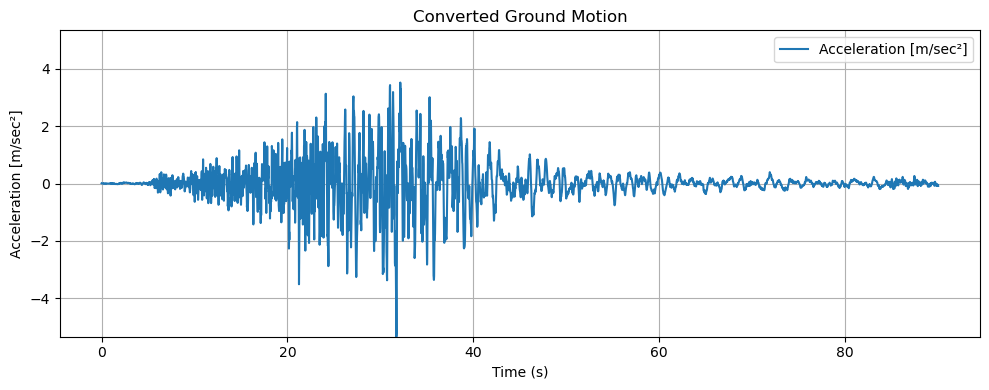

✅ Converted file saved to 'DarfieldX.dat'
0.02 4502


In [6]:
import signals as sig
g   = 9.8
loadConst('-time', 0.0)                        # Set the gravity loads to be constant & reset the time in the domain

dt , npts = sig.morsa_to_opensees("GEN_acc_RotD100RotDarfie2010Wakc_Y.txt", 
                  "DarfieldY.dat", 
                  scale_factor=g, 
                  plot=True)
dt , npts = sig.morsa_to_opensees("GEN_acc_RotD100RotDarfie2010Wakc_X.txt", 
                  "DarfieldX.dat", 
                  scale_factor=g, 
                  plot=False)

print(dt, npts)


timeSeries('Path', 2,  '-filePath', 'DarfieldX.dat', '-dt', 0.02, '-factor', 1.0)  # Set time series to be passed to uniform excitation
timeSeries('Path', 3,  '-filePath', 'DarfieldY.dat', '-dt', 0.02, '-factor', 1.0)
#                            tag , dir ,....,tseriesTag 
pattern('UniformExcitation',  2  , 1, '-accel', 2)                      # Create UniformExcitation load pattern along UX
pattern('UniformExcitation',  3  , 2, '-accel', 3)                      # Create UniformExcitation load pattern along UY
rayleigh(0.1416, 0.0, 0.0, 0.00281)

In [7]:
wipeAnalysis()
tolerance = 1.0e-3
constraints('Transformation')    
numberer('RCM')                                    # Reverse Cuthill-McKee DOF numbering
system('SparseGeneral')                            # Solver for large systems
test('EnergyIncr', tolerance, 20 , 1)              # Convergence test: energy norm, tolerance, max iterations
algorithm('ModifiedNewton', '-initial')            # Modified Newton-Raphson algorithm
integrator('Newmark', 0.5, 0.25)                   # Newmark method (β=0.25, γ=0.5 for constant average)
analysis('Transient')                              # Type of analysis: transient (time history)  

In [8]:
# Perform a first eigenvalue analysis
#
from math import sqrt, pi
numEigen = 5
eigenValues = eigen(numEigen)
print("eigen values at start of transient:",eigenValues)
for i, lam in enumerate(eigenValues):
    if lam > 0:
        freq = sqrt(lam) / (2 * pi)
        period = 1 / freq
        print(f"Mode {i+1}: Frequency = {freq:.3f} Hz, Period = {period:.3f} s")
    else:
        print(f"Mode {i+1}: Invalid eigenvalue (λ = {lam})")

eigen values at start of transient: [127.21442154905185, 132.21687383325607, 150.2558983560557, 397.8043889137597, 955.644879489837]
Mode 1: Frequency = 1.795 Hz, Period = 0.557 s
Mode 2: Frequency = 1.830 Hz, Period = 0.546 s
Mode 3: Frequency = 1.951 Hz, Period = 0.513 s
Mode 4: Frequency = 3.174 Hz, Period = 0.315 s
Mode 5: Frequency = 4.920 Hz, Period = 0.203 s


In [9]:
tFinal = npts*dt
tCurrent = getTime()
#print("Final Time =" , tFinal)
ok = 0
time = [tCurrent]
uRef_x = [0.0]
uRef_y = [0.0]
uRef_z = [0.0]
#
# Perform the transient analysis
#
while ok == 0 and tCurrent < tFinal:    
    ok = analyze(1 , dt)        
    if ok != 0:
        print("regular newton failed .. lets try an initail stiffness for this step")
        test('NormDispIncr', tolerance , 100 , 0)
        algorithm('ModifiedNewton', '-initial')                                         # if the analysis fails try initial tangent iteration
        ok =analyze( 1, dt)
        if ok == 0:
            print("that worked .. back to regular newton")
        test('NormDispIncr', tolerance,  10 )
        algorithm('Newton')
        
    tCurrent = getTime()
    time.append(tCurrent)
    uRef_x.append(nodeDisp(1384010,1))
    uRef_y.append(nodeDisp(1384010,2))
    uRef_z.append(nodeDisp(1384010,3))

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.41574e-19 (max: 0.001)



0.02
0.04


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22509e-17 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68476e-17 (max: 0.001)



0.06


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03724e-16 (max: 0.001)



0.08
0.1


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.95281e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26818e-16 (max: 0.001)



0.12000000000000001
0.14


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.10468e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.65582e-17 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.67676e-17 (max: 0.001)



0.16
0.18
0.19999999999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.19152e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.66084e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81637e-15 (max: 0.001)



0.21999999999999997
0.23999999999999996
0.25999999999999995
0.27999999999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06224e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80984e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47611e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46169e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77365e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68209e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.64492e-15 (max: 0.001)



0.3
0.32
0.34
0.36000000000000004
0.38000000000000006
0.4000000000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69031e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00664e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08539e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.98406e-17 (max: 0.001)



0.4200000000000001
0.4400000000000001
0.46000000000000013
0.48000000000000015


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.04801e-18 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18745e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65087e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.02645e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.00384e-15 (max: 0.001)



0.5000000000000001
0.5200000000000001
0.5400000000000001
0.5600000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.93237e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.04797e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.18486e-15 (max: 0.001)



0.5800000000000002
0.6000000000000002
0.6200000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.30757e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1666e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54508e-15 (max: 0.001)



0.6400000000000002
0.6600000000000003
0.6800000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10476e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.31562e-17 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.44206e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.15871e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91293e-15 (max: 0.001)



0.7000000000000003
0.7200000000000003
0.7400000000000003
0.7600000000000003
0.7800000000000004


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.44559e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.92221e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.30005e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.94919e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.7902e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.15034e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.94081e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41713e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.61689e-17 (max: 0.001)



0.8000000000000004
0.8200000000000004
0.8400000000000004
0.8600000000000004
0.8800000000000004
0.9000000000000005
0.9200000000000005
0.9400000000000005
0.9600000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14244e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.36262e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.29351e-15 (max: 0.001)



0.9800000000000005
1.0000000000000004
1.0200000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18617e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6525e-14 (max: 0.001)



1.0400000000000005
1.0600000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70361e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42523e-14 (max: 0.001)



1.0800000000000005
1.1000000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20925e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.7125e-15 (max: 0.001)



1.1200000000000006
1.1400000000000006
1.1600000000000006


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.35147e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98823e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35334e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.46951e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.32662e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13858e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32128e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27469e-14 (max: 0.001)



1.1800000000000006
1.2000000000000006
1.2200000000000006
1.2400000000000007
1.2600000000000007
1.2800000000000007
1.3000000000000007
1.3200000000000007


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36253e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10029e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.52349e-15 (max: 0.001)



1.3400000000000007
1.3600000000000008
1.3800000000000008
1.4000000000000008
1.4200000000000008
1.4400000000000008


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.82407e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.15862e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.96616e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07301e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59745e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03725e-15 (max: 0.001)



1.4600000000000009
1.4800000000000009
1.5000000000000009


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41075e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.84406e-16 (max: 0.001)



1.520000000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.3668e-16 (max: 0.001)



1.540000000000001
1.560000000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59236e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.22779e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00691e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67896e-15 (max: 0.001)



1.580000000000001
1.600000000000001
1.620000000000001
1.640000000000001
1.660000000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57703e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00265e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13461e-15 (max: 0.001)



1.680000000000001
1.700000000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22465e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3484e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1867e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.8194e-18 (max: 0.001)



1.720000000000001
1.740000000000001
1.7600000000000011
1.7800000000000011
1.8000000000000012


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.23811e-17 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85882e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.27948e-16 (max: 0.001)



1.8200000000000012
1.8400000000000012
1.8600000000000012
1.8800000000000012


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90356e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42391e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56084e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.35572e-15 (max: 0.001)



1.9000000000000012
1.9200000000000013


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.20782e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.95899e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18168e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70026e-14 (max: 0.001)



1.9400000000000013
1.9600000000000013
1.9800000000000013
2.0000000000000013
2.0200000000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.08071e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31049e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.51142e-14 (max: 0.001)



2.0400000000000014
2.0600000000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79086e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.97077e-14 (max: 0.001)



2.0800000000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50791e-14 (max: 0.001)



2.1000000000000014
2.1200000000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.562e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84675e-14 (max: 0.001)



2.1400000000000015


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09071e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.78874e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.87755e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29465e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21933e-14 (max: 0.001)



2.1600000000000015
2.1800000000000015
2.2000000000000015
2.2200000000000015
2.2400000000000015


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.11473e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.50001e-14 (max: 0.001)



2.2600000000000016
2.2800000000000016
2.3000000000000016
2.3200000000000016


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.59476e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.66098e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.29824e-14 (max: 0.001)



2.3400000000000016
2.3600000000000017


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29761e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10823e-15 (max: 0.001)



2.3800000000000017
2.4000000000000017
2.4200000000000017


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.38772e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22724e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.87163e-14 (max: 0.001)



2.4400000000000017
2.4600000000000017


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.10726e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.25424e-14 (max: 0.001)



2.4800000000000018
2.5000000000000018
2.520000000000002
2.540000000000002
2.560000000000002
2.580000000000002
2.600000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.73561e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.55517e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.92197e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.83068e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59428e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75364e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.45377e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78386e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.42646e-15 (max: 0.001)



2.620000000000002
2.640000000000002
2.660000000000002
2.680000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.65555e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65597e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77276e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.82177e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.59794e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.14203e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.22917e-14 (max: 0.001)



2.700000000000002
2.720000000000002
2.740000000000002
2.760000000000002
2.780000000000002
2.800000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01555e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.70266e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.6519e-14 (max: 0.001)



2.820000000000002
2.840000000000002
2.860000000000002
2.880000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.20088e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.04886e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.13101e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.81753e-15 (max: 0.001)



2.900000000000002
2.920000000000002
2.940000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.31768e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33699e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60211e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21008e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.47443e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.63419e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71581e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1705e-14 (max: 0.001)



2.960000000000002
2.980000000000002
3.000000000000002
3.0200000000000022
3.0400000000000023
3.0600000000000023
3.0800000000000023
3.1000000000000023


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75743e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33653e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.79396e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.77545e-16 (max: 0.001)



3.1200000000000023
3.1400000000000023
3.1600000000000024
3.1800000000000024


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.03036e-15 (max: 0.001)



3.2000000000000024


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96789e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.34985e-14 (max: 0.001)



3.2200000000000024
3.2400000000000024


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.79914e-14 (max: 0.001)



3.2600000000000025
3.2800000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.07827e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.86275e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.45088e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.03613e-14 (max: 0.001)



3.3000000000000025
3.3200000000000025
3.3400000000000025
3.3600000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.25614e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13026e-14 (max: 0.001)



3.3800000000000026
3.4000000000000026


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0807e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07104e-16 (max: 0.001)



3.4200000000000026
3.4400000000000026


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.154e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16301e-14 (max: 0.001)



3.4600000000000026
3.4800000000000026


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34887e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.48239e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.12507e-14 (max: 0.001)



3.5000000000000027
3.5200000000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.0756e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86128e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01476e-14 (max: 0.001)



3.5400000000000027
3.5600000000000027
3.5800000000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62204e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.4744e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3771e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97916e-15 (max: 0.001)



3.6000000000000028
3.6200000000000028
3.640000000000003
3.660000000000003
3.680000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36732e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.30128e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.45131e-15 (max: 0.001)



3.700000000000003
3.720000000000003
3.740000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.93869e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25442e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.07124e-15 (max: 0.001)



3.760000000000003
3.780000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.19606e-15 (max: 0.001)



3.800000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09787e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32263e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14337e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4556e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.82528e-15 (max: 0.001)



3.820000000000003
3.840000000000003
3.860000000000003
3.880000000000003
3.900000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.84726e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.2239e-15 (max: 0.001)



3.920000000000003
3.940000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08839e-14 (max: 0.001)



3.960000000000003
3.980000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03906e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11361e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71424e-14 (max: 0.001)



4.000000000000003
4.020000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.61307e-14 (max: 0.001)



4.040000000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93381e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60621e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00542e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27126e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.15295e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00971e-14 (max: 0.001)



4.060000000000001
4.080000000000001
4.1000000000000005
4.12
4.14
4.159999999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.8854e-14 (max: 0.001)



4.179999999999999
4.199999999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16041e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.61294e-14 (max: 0.001)



4.219999999999998
4.2399999999999975


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.97397e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.44294e-14 (max: 0.001)



4.259999999999997
4.279999999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.37807e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09991e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.03465e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85109e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.63445e-14 (max: 0.001)



4.299999999999996
4.319999999999996
4.339999999999995
4.359999999999995
4.379999999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.86298e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76439e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48065e-13 (max: 0.001)



4.399999999999994
4.419999999999994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.71282e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09196e-13 (max: 0.001)



4.439999999999993
4.459999999999993


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1691e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.51842e-14 (max: 0.001)



4.479999999999992
4.499999999999992
4.519999999999992


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09164e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20997e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.80391e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72405e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.44592e-13 (max: 0.001)



4.539999999999991
4.559999999999991
4.57999999999999
4.59999999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90618e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.4856e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13795e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.40319e-13 (max: 0.001)



4.6199999999999894
4.639999999999989
4.659999999999989
4.679999999999988


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49848e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.65253e-14 (max: 0.001)



4.699999999999988
4.719999999999987
4.739999999999987


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.07808e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.02578e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.65972e-14 (max: 0.001)



4.7599999999999865
4.779999999999986


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02347e-13 (max: 0.001)



4.799999999999986
4.819999999999985
4.839999999999985


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43515e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53818e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26051e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20881e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08233e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09772e-13 (max: 0.001)



4.859999999999984
4.879999999999984
4.8999999999999835
4.919999999999983


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28446e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46107e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37331e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22143e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05738e-13 (max: 0.001)



4.939999999999983
4.959999999999982
4.979999999999982
4.999999999999981
5.019999999999981


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.83886e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.40587e-14 (max: 0.001)



5.0399999999999805
5.05999999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49985e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.36893e-16 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.48363e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93615e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.74945e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.03976e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.59611e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.25275e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.55839e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.86502e-13 (max: 0.001)



5.07999999999998
5.099999999999979
5.119999999999979
5.139999999999978
5.159999999999978
5.1799999999999775
5.199999999999977
5.219999999999977
5.239999999999976
5.259999999999976
5.279999999999975


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35462e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.52248e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38778e-14 (max: 0.001)



5.299999999999975
5.3199999999999745
5.339999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03316e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01509e-13 (max: 0.001)



5.359999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71419e-14 (max: 0.001)



5.379999999999973


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.29872e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.86033e-13 (max: 0.001)



5.399999999999973
5.419999999999972


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.18877e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.31347e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.2317e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.44189e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44106e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10741e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.25494e-14 (max: 0.001)



5.439999999999972
5.4599999999999715
5.479999999999971
5.499999999999971
5.51999999999997
5.53999999999997
5.559999999999969


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.13468e-15 (max: 0.001)



5.579999999999969


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.52232e-14 (max: 0.001)



5.599999999999969


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.52095e-14 (max: 0.001)



5.619999999999968


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48019e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68696e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.5852e-13 (max: 0.001)



5.639999999999968
5.659999999999967
5.679999999999967


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.23676e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.68675e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.18798e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95811e-14 (max: 0.001)



5.699999999999966
5.719999999999966
5.739999999999966
5.759999999999965


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.71402e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57977e-12 (max: 0.001)



5.779999999999965
5.799999999999964


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.50514e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.36828e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30288e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26118e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.26881e-13 (max: 0.001)



5.819999999999964
5.839999999999963
5.859999999999963
5.879999999999963
5.899999999999962
5.919999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.75439e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69818e-14 (max: 0.001)



5.939999999999961
5.959999999999961
5.9799999999999605


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42298e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.13945e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41419e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83424e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35284e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.05434e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.7582e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72049e-14 (max: 0.001)



5.99999999999996
6.01999999999996
6.039999999999959
6.059999999999959
6.079999999999958
6.099999999999958


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00989e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5621e-13 (max: 0.001)



6.1199999999999575
6.139999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1928e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04516e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.23053e-14 (max: 0.001)



6.159999999999957
6.179999999999956
6.199999999999956


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21986e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80358e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.15448e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.3318e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.36729e-13 (max: 0.001)



6.219999999999955
6.239999999999955
6.2599999999999545
6.279999999999954
6.299999999999954


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.88532e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.08123e-13 (max: 0.001)



6.319999999999953
6.339999999999953


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78198e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.41693e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79134e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.996e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.28179e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.894e-14 (max: 0.001)



6.359999999999952
6.379999999999952
6.3999999999999515
6.419999999999951
6.439999999999951
6.45999999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.11337e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.58464e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10287e-13 (max: 0.001)



6.47999999999995
6.499999999999949
6.519999999999949


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48445e-14 (max: 0.001)



6.5399999999999485
6.559999999999948


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02818e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.75439e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.87061e-13 (max: 0.001)



6.579999999999948
6.599999999999947


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37926e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.40804e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9788e-13 (max: 0.001)



6.619999999999947
6.639999999999946
6.659999999999946
6.6799999999999455


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.63228e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1645e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43487e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.72628e-13 (max: 0.001)



6.699999999999945
6.719999999999945
6.739999999999944
6.759999999999944


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.44249e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43288e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05983e-12 (max: 0.001)



6.779999999999943
6.799999999999943
6.8199999999999426


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.20036e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.6248e-14 (max: 0.001)



6.839999999999942
6.859999999999942


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48823e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53231e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9541e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.75944e-12 (max: 0.001)



6.879999999999941
6.899999999999941
6.91999999999994
6.93999999999994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.58426e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.4288e-13 (max: 0.001)



6.95999999999994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.11687e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70442e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1533e-13 (max: 0.001)



6.979999999999939
6.999999999999939
7.019999999999938


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.80869e-13 (max: 0.001)



7.039999999999938


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86612e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24971e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03138e-12 (max: 0.001)



7.059999999999937
7.079999999999937
7.099999999999937
7.119999999999936


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97015e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.97942e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1319e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13784e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30545e-13 (max: 0.001)



7.139999999999936
7.159999999999935
7.179999999999935
7.1999999999999345


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.19152e-14 (max: 0.001)



7.219999999999934


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.90387e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22184e-13 (max: 0.001)



7.239999999999934
7.259999999999933


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36739e-12 (max: 0.001)



7.279999999999933
7.299999999999932


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.35745e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.14491e-12 (max: 0.001)



7.319999999999932
7.3399999999999315


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.60002e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1522e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65002e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61623e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60596e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52911e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10192e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.47498e-13 (max: 0.001)



7.359999999999931
7.379999999999931
7.39999999999993
7.41999999999993
7.439999999999929
7.459999999999929
7.4799999999999285


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.73499e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.36413e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88355e-12 (max: 0.001)



7.499999999999928
7.519999999999928
7.539999999999927
7.559999999999927


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.03366e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68099e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.24548e-13 (max: 0.001)



7.579999999999926
7.599999999999926
7.6199999999999255
7.639999999999925
7.659999999999925
7.679999999999924


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79069e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.40417e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.45871e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15678e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.19003e-13 (max: 0.001)



7.699999999999924
7.719999999999923


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65155e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30033e-12 (max: 0.001)



7.739999999999923


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48677e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39037e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53096e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68658e-13 (max: 0.001)



7.7599999999999225
7.779999999999922
7.799999999999922
7.819999999999921


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.79495e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23078e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.39747e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6585e-12 (max: 0.001)



7.839999999999921
7.85999999999992
7.87999999999992
7.8999999999999195


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72468e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.56893e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50558e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30916e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.71247e-12 (max: 0.001)



7.919999999999919
7.939999999999919
7.959999999999918
7.979999999999918
7.999999999999917


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.82289e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07189e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2756e-12 (max: 0.001)



8.019999999999918
8.039999999999917
8.059999999999917


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.27373e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84812e-13 (max: 0.001)



8.079999999999917
8.099999999999916


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.34923e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34551e-12 (max: 0.001)



8.119999999999916
8.139999999999915


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47236e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21874e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.2557e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.62901e-13 (max: 0.001)



8.159999999999915
8.179999999999914
8.199999999999914
8.219999999999914


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59164e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.74388e-13 (max: 0.001)



8.239999999999913
8.259999999999913


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78451e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35762e-12 (max: 0.001)



8.279999999999912
8.299999999999912


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59966e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.15644e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.94837e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.73628e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15355e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16805e-12 (max: 0.001)



8.319999999999911
8.339999999999911
8.35999999999991
8.37999999999991
8.39999999999991
8.41999999999991


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0579e-12 (max: 0.001)



8.439999999999909


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.10888e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.30677e-13 (max: 0.001)



8.459999999999908
8.479999999999908


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10393e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21897e-12 (max: 0.001)



8.499999999999908
8.519999999999907


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99107e-12 (max: 0.001)



8.539999999999907
8.559999999999906


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.98133e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97833e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.95204e-13 (max: 0.001)



8.579999999999906
8.599999999999905
8.619999999999905
8.639999999999905


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.31532e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08542e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17352e-12 (max: 0.001)



8.659999999999904
8.679999999999904
8.699999999999903


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.7622e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7606e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.60908e-13 (max: 0.001)



8.719999999999903
8.739999999999903


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6246e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46313e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.23869e-12 (max: 0.001)



8.759999999999902
8.779999999999902


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1658e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50169e-11 (max: 0.001)



8.799999999999901
8.8199999999999
8.8399999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69833e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33208e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.18786e-12 (max: 0.001)



8.8599999999999
8.8799999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.2695e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2491e-12 (max: 0.001)



8.899999999999899
8.919999999999899


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.13297e-13 (max: 0.001)



8.939999999999898
8.959999999999898


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89737e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.065e-12 (max: 0.001)



8.979999999999897
8.999999999999897


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47378e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46812e-11 (max: 0.001)



9.019999999999897
9.039999999999896
9.059999999999896


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01795e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16564e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65195e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02751e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1458e-11 (max: 0.001)



9.079999999999895
9.099999999999895
9.119999999999894
9.139999999999894


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.39625e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.16426e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65598e-12 (max: 0.001)



9.159999999999894
9.179999999999893
9.199999999999893


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.85784e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.41474e-13 (max: 0.001)



9.219999999999892
9.239999999999892


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90878e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.55613e-12 (max: 0.001)



9.259999999999891
9.279999999999891


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98549e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07377e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.81125e-11 (max: 0.001)



9.29999999999989
9.31999999999989
9.33999999999989
9.35999999999989


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.70163e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.50121e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.76135e-11 (max: 0.001)



9.379999999999889
9.399999999999888
9.419999999999888


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6879e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.86957e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.42645e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79359e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57597e-12 (max: 0.001)



9.439999999999888
9.459999999999887
9.479999999999887
9.499999999999886


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.7073e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80679e-11 (max: 0.001)



9.519999999999886
9.539999999999885


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00246e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60605e-11 (max: 0.001)



9.559999999999885
9.579999999999885


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.08819e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.54912e-11 (max: 0.001)



9.599999999999884
9.619999999999884


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.44586e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70693e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.4864e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80451e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63961e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.32359e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46272e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.86504e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20066e-11 (max: 0.001)



9.639999999999883
9.659999999999883
9.679999999999882
9.699999999999882
9.719999999999882
9.739999999999881
9.75999999999988
9.77999999999988
9.79999999999988


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63825e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96759e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28351e-11 (max: 0.001)



9.81999999999988
9.839999999999879
9.859999999999879
9.879999999999878


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96227e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.27694e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11541e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83594e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29824e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.58892e-12 (max: 0.001)



9.899999999999878
9.919999999999877
9.939999999999877
9.959999999999877
9.979999999999876


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93316e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.55279e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86425e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01133e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69234e-11 (max: 0.001)



9.999999999999876
10.019999999999875
10.039999999999875
10.059999999999874
10.079999999999874


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88044e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.32624e-11 (max: 0.001)



10.099999999999874


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.60239e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20993e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.80562e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.72906e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.23897e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.16967e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.85737e-11 (max: 0.001)



10.119999999999873
10.139999999999873
10.159999999999872
10.179999999999872
10.199999999999871
10.219999999999871
10.23999999999987


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5027e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49216e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04716e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11513e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71049e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.13327e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7784e-11 (max: 0.001)



10.25999999999987
10.27999999999987
10.29999999999987
10.319999999999869
10.339999999999868
10.359999999999868
10.379999999999868
10.399999999999867


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.7847e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.26562e-14 (max: 0.001)



10.419999999999867
10.439999999999866


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.85291e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47884e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.38459e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63985e-11 (max: 0.001)



10.459999999999866
10.479999999999865
10.499999999999865


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66647e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.81587e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18095e-12 (max: 0.001)



10.519999999999865
10.539999999999864
10.559999999999864


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.99819e-13 (max: 0.001)



10.579999999999863
10.599999999999863


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.97555e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.97925e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.34203e-12 (max: 0.001)



10.619999999999862
10.639999999999862
10.659999999999862


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19696e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.59766e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20955e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.90225e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.94892e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.66601e-12 (max: 0.001)



10.679999999999861
10.69999999999986
10.71999999999986
10.73999999999986
10.75999999999986
10.779999999999859


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.00388e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.05415e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0662e-12 (max: 0.001)



10.799999999999859
10.819999999999858


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5529e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.0828e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.8093e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.69872e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03683e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.48183e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.43828e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57054e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.57766e-13 (max: 0.001)



10.839999999999858
10.859999999999857
10.879999999999857
10.899999999999856
10.919999999999856
10.939999999999856
10.959999999999855
10.979999999999855
10.999999999999854


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.72808e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60731e-12 (max: 0.001)



11.019999999999854
11.039999999999853


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.91296e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51012e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6472e-11 (max: 0.001)



11.059999999999853
11.079999999999853
11.099999999999852


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84984e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02888e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10377e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71197e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15423e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61393e-13 (max: 0.001)



11.119999999999852
11.139999999999851
11.159999999999851
11.17999999999985
11.19999999999985
11.21999999999985


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.92119e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.33356e-13 (max: 0.001)



11.23999999999985
11.259999999999849


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72405e-12 (max: 0.001)



11.279999999999848


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20775e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4241e-11 (max: 0.001)



11.299999999999848
11.319999999999848


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.0359e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63775e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63146e-11 (max: 0.001)



11.339999999999847
11.359999999999847
11.379999999999846


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.67486e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.81375e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.19919e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00242e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.50922e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.34151e-13 (max: 0.001)



11.399999999999846
11.419999999999845
11.439999999999845
11.459999999999845
11.479999999999844
11.499999999999844
11.519999999999843


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.02694e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.9672e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.9467e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.76405e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1648e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15035e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19519e-11 (max: 0.001)



11.539999999999843
11.559999999999842
11.579999999999842
11.599999999999842
11.619999999999841
11.63999999999984
11.65999999999984


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59665e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.29644e-12 (max: 0.001)



11.67999999999984
11.69999999999984
11.719999999999839


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.74468e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.94058e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59364e-12 (max: 0.001)



11.739999999999839
11.759999999999838
11.779999999999838
11.799999999999837
11.819999999999837
11.839999999999836


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.73699e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1258e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.11539e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04527e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50811e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.48043e-12 (max: 0.001)



11.859999999999836
11.879999999999836


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.77402e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.61188e-12 (max: 0.001)



11.899999999999835
11.919999999999835
11.939999999999834


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00779e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90917e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.8309e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46139e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78978e-13 (max: 0.001)



11.959999999999834
11.979999999999833
11.999999999999833
12.019999999999833
12.039999999999832
12.059999999999832


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.84374e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.11452e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.49038e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1821e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.55083e-13 (max: 0.001)



12.079999999999831
12.099999999999831
12.11999999999983
12.13999999999983


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57109e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.111e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81141e-12 (max: 0.001)



12.15999999999983
12.17999999999983


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55553e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.72129e-12 (max: 0.001)



12.199999999999829
12.219999999999828
12.239999999999828


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.23726e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92907e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89045e-12 (max: 0.001)



12.259999999999827


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.4897e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57204e-11 (max: 0.001)



12.279999999999827
12.299999999999827


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31136e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16082e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18736e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84833e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41425e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63735e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86696e-11 (max: 0.001)



12.319999999999826
12.339999999999826
12.359999999999825
12.379999999999825
12.399999999999824
12.419999999999824
12.439999999999824


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.27324e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1313e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.25407e-12 (max: 0.001)



12.459999999999823
12.479999999999823
12.499999999999822
12.519999999999822


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41641e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86657e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.47634e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.95371e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58741e-11 (max: 0.001)



12.539999999999822
12.559999999999821
12.57999999999982
12.59999999999982
12.61999999999982


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88278e-11 (max: 0.001)



12.63999999999982


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.61769e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.79084e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2869e-11 (max: 0.001)



12.659999999999819
12.679999999999819
12.699999999999818


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20546e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.58161e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.98822e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1953e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.26027e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.45942e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10027e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.70073e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.50775e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60566e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.08638e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1879e

12.719999999999818
12.739999999999817
12.759999999999817
12.779999999999816
12.799999999999816
12.819999999999816
12.839999999999815
12.859999999999815
12.879999999999814
12.899999999999814
12.919999999999813
12.939999999999813
12.959999999999813
12.979999999999812


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25527e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.83979e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07267e-11 (max: 0.001)



12.999999999999812
13.019999999999811
13.03999999999981


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.6519e-12 (max: 0.001)



13.05999999999981


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11535e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.69233e-12 (max: 0.001)



13.07999999999981
13.09999999999981


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.47863e-12 (max: 0.001)



13.11999999999981
13.139999999999809


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.44199e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26067e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12121e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.6858e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.55428e-12 (max: 0.001)



13.159999999999808
13.179999999999808
13.199999999999807
13.219999999999807


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.3581e-12 (max: 0.001)



13.239999999999807


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29276e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.86349e-12 (max: 0.001)



13.259999999999806
13.279999999999806


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.28867e-11 (max: 0.001)



13.299999999999805
13.319999999999805


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10976e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.82608e-11 (max: 0.001)



13.339999999999804
13.359999999999804


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.65962e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22149e-11 (max: 0.001)



13.379999999999804


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83536e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98796e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66077e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43218e-11 (max: 0.001)



13.399999999999803
13.419999999999803
13.439999999999802
13.459999999999802


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.85363e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24516e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.84179e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.33734e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.40187e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.55892e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.37042e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.90227e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.48514e-11 (max: 0.001)



13.479999999999801
13.499999999999801
13.5199999999998
13.5399999999998
13.5599999999998
13.5799999999998
13.599999999999799
13.619999999999798
13.639999999999798
13.659999999999798
13.679999999999797


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.52996e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04713e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96029e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.53923e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.87809e-11 (max: 0.001)



13.699999999999797
13.719999999999796
13.739999999999796
13.759999999999796
13.779999999999795


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06031e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72759e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.53138e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3578e-10 (max: 0.001)



13.799999999999795
13.819999999999794
13.839999999999794


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50093e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.45204e-10 (max: 0.001)



13.859999999999793
13.879999999999793


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08744e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.5257e-11 (max: 0.001)



13.899999999999793
13.919999999999792


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.26463e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.12363e-11 (max: 0.001)



13.939999999999792
13.959999999999791


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.7241e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03949e-11 (max: 0.001)



13.97999999999979
13.99999999999979


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.06135e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91851e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63323e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.29312e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.0022e-11 (max: 0.001)



14.01999999999979
14.03999999999979
14.059999999999789
14.079999999999789
14.099999999999788


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.41668e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37861e-11 (max: 0.001)



14.119999999999788
14.139999999999787
14.159999999999787
14.179999999999787


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65825e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18201e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.1494e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55607e-11 (max: 0.001)



14.199999999999786


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.92871e-11 (max: 0.001)



14.219999999999786
14.239999999999785
14.259999999999785
14.279999999999784
14.299999999999784


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59489e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47775e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.93981e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.0144e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.03675e-12 (max: 0.001)



14.319999999999784
14.339999999999783


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69565e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.00145e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53058e-11 (max: 0.001)



14.359999999999783
14.379999999999782


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.82125e-11 (max: 0.001)



14.399999999999782


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58043e-11 (max: 0.001)



14.419999999999781


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80671e-11 (max: 0.001)



14.439999999999781
14.45999999999978


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03676e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.0234e-11 (max: 0.001)



14.47999999999978
14.49999999999978
14.51999999999978


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.17499e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.94506e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.3629e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70814e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07931e-11 (max: 0.001)



14.539999999999779
14.559999999999778
14.579999999999778
14.599999999999778


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54186e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14831e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79643e-11 (max: 0.001)



14.619999999999777
14.639999999999777
14.659999999999776
14.679999999999776


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.9276e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46056e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.99822e-11 (max: 0.001)



14.699999999999775
14.719999999999775


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.02631e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00921e-10 (max: 0.001)



14.739999999999775
14.759999999999774
14.779999999999774
14.799999999999773


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.81642e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.29576e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02508e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.01374e-13 (max: 0.001)



14.819999999999773
14.839999999999772


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.20274e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10554e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62076e-11 (max: 0.001)



14.859999999999772
14.879999999999772
14.899999999999771
14.91999999999977


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47749e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84994e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24133e-11 (max: 0.001)



14.93999999999977
14.95999999999977


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.368e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06487e-11 (max: 0.001)



14.97999999999977
14.999999999999769
15.019999999999769


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.61332e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.5474e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.82041e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33387e-12 (max: 0.001)



15.039999999999768
15.059999999999768
15.079999999999767


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07153e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.58143e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.74821e-12 (max: 0.001)



15.099999999999767
15.119999999999767
15.139999999999766


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98737e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.08837e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43607e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54849e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.94527e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.43513e-12 (max: 0.001)



15.159999999999766
15.179999999999765
15.199999999999765
15.219999999999764
15.239999999999764
15.259999999999764


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.46277e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.85152e-12 (max: 0.001)



15.279999999999763
15.299999999999763


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.63812e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75395e-11 (max: 0.001)



15.319999999999762


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20081e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.29912e-12 (max: 0.001)



15.339999999999762
15.359999999999761


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72664e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.42991e-11 (max: 0.001)



15.379999999999761
15.39999999999976


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.66344e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.63399e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.37585e-11 (max: 0.001)



15.41999999999976
15.43999999999976
15.45999999999976


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2516e-11 (max: 0.001)



15.479999999999759
15.499999999999758


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83794e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.63726e-12 (max: 0.001)



15.519999999999758
15.539999999999758


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47083e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46908e-12 (max: 0.001)



15.559999999999757
15.579999999999757


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42236e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.37662e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39497e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56062e-11 (max: 0.001)



15.599999999999756
15.619999999999756
15.639999999999755
15.659999999999755


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.56037e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62997e-11 (max: 0.001)



15.679999999999755
15.699999999999754


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.41096e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.09669e-11 (max: 0.001)



15.719999999999754
15.739999999999753


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.28018e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.86028e-11 (max: 0.001)



15.759999999999753
15.779999999999752
15.799999999999752
15.819999999999752
15.839999999999751


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.58584e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93481e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.82906e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.62192e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.3778e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.86785e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.00795e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13408e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24126e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20391e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1734e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.22169e

15.85999999999975
15.87999999999975
15.89999999999975
15.91999999999975
15.939999999999749
15.959999999999749
15.979999999999748
15.999999999999748
16.019999999999747


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.51269e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.72353e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37246e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.801e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48532e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11286e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.83649e-11 (max: 0.001)



16.039999999999747
16.059999999999746
16.079999999999746
16.099999999999746
16.119999999999745
16.139999999999745
16.159999999999744


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.6537e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.21053e-11 (max: 0.001)



16.179999999999744
16.199999999999743


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.51215e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.36369e-11 (max: 0.001)



16.219999999999743
16.239999999999743


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.29519e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.67351e-11 (max: 0.001)



16.259999999999742
16.279999999999742


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.44584e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.49522e-11 (max: 0.001)



16.29999999999974
16.31999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69289e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15207e-11 (max: 0.001)



16.33999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82687e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35337e-11 (max: 0.001)



16.35999999999974
16.37999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29459e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50992e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.46163e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.17775e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.22246e-11 (max: 0.001)



16.39999999999974
16.41999999999974
16.43999999999974
16.459999999999738
16.479999999999738
16.499999999999737
16.519999999999737


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78932e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.62384e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86602e-10 (max: 0.001)



16.539999999999736


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47841e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09779e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67708e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19887e-10 (max: 0.001)



16.559999999999736
16.579999999999735
16.599999999999735
16.619999999999735
16.639999999999734


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.57084e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.21004e-11 (max: 0.001)



16.659999999999734


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91596e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34188e-12 (max: 0.001)



16.679999999999733
16.699999999999733


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.31642e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30077e-10 (max: 0.001)



16.719999999999732
16.739999999999732


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.18981e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.72792e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.74957e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.17905e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06447e-10 (max: 0.001)



16.75999999999973
16.77999999999973
16.79999999999973
16.81999999999973
16.83999999999973
16.85999999999973


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54916e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49786e-10 (max: 0.001)



16.87999999999973
16.89999999999973


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69372e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66393e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.49862e-11 (max: 0.001)



16.919999999999728
16.939999999999728
16.959999999999727


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.35184e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.36028e-11 (max: 0.001)



16.979999999999727
16.999999999999726


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16439e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.18317e-10 (max: 0.001)



17.019999999999726
17.039999999999726


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.72124e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91733e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.04787e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.98509e-10 (max: 0.001)



17.059999999999725
17.079999999999725
17.099999999999724
17.119999999999724


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41061e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89672e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14065e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53543e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54692e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21408e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99781e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89568e-11 (max: 0.001)



17.139999999999723
17.159999999999723
17.179999999999723
17.199999999999722
17.21999999999972
17.23999999999972
17.25999999999972


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.7623e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.11437e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.33311e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71772e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.58195e-11 (max: 0.001)



17.27999999999972
17.29999999999972
17.31999999999972
17.33999999999972
17.35999999999972


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.50992e-11 (max: 0.001)



17.37999999999972


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.38182e-11 (max: 0.001)



17.399999999999718


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.46469e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.62652e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6908e-11 (max: 0.001)



17.419999999999717
17.439999999999717
17.459999999999717
17.479999999999716
17.499999999999716
17.519999999999715


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.36813e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.94939e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.794e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.23593e-11 (max: 0.001)



17.539999999999715
17.559999999999715
17.579999999999714


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.7328e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10309e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52428e-10 (max: 0.001)



17.599999999999714
17.619999999999713


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41239e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07173e-10 (max: 0.001)



17.639999999999713
17.659999999999712


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60784e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00178e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52879e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.83669e-11 (max: 0.001)



17.679999999999712
17.69999999999971
17.71999999999971
17.73999999999971
17.75999999999971
17.77999999999971
17.79999999999971
17.81999999999971
17.83999999999971
17.859999999999708


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0712e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20647e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3924e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36234e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25926e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.70298e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.88633e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5273e-11 (max: 0.001)



17.879999999999708
17.899999999999707
17.919999999999707


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.76497e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24142e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83373e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25856e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75291e-11 (max: 0.001)



17.939999999999706
17.959999999999706
17.979999999999706
17.999999999999705
18.019999999999705
18.039999999999704
18.059999999999704


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.93643e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.77908e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16302e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.94113e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.48815e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.19517e-11 (max: 0.001)



18.079999999999703
18.099999999999703
18.119999999999703
18.139999999999702
18.1599999999997
18.1799999999997
18.1999999999997
18.2199999999997
18.2399999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83859e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.29111e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70548e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91533e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.18471e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.18023e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.46531e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.42945e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.89209e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.59632e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.57202e-11 (max: 0.001)



18.2599999999997
18.2799999999997
18.2999999999997
18.3199999999997
18.339999999999698


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12807e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0464e-12 (max: 0.001)



18.359999999999697
18.379999999999697


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70746e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.77075e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55239e-10 (max: 0.001)



18.399999999999697
18.419999999999696
18.439999999999696


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8826e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66074e-10 (max: 0.001)



18.459999999999695
18.479999999999695
18.499999999999694
18.519999999999694


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16321e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.49015e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.46233e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.37254e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.99918e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.42015e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.58069e-12 (max: 0.001)



18.539999999999694
18.559999999999693
18.579999999999693
18.599999999999692
18.619999999999692


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59484e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.92063e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4629e-10 (max: 0.001)



18.63999999999969
18.65999999999969
18.67999999999969


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25061e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.51429e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21068e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53617e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14208e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.29916e-11 (max: 0.001)



18.69999999999969
18.71999999999969
18.73999999999969
18.75999999999969
18.77999999999969
18.799999999999688


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.12993e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98109e-11 (max: 0.001)



18.819999999999688
18.839999999999687
18.859999999999687


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77727e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64892e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26994e-12 (max: 0.001)



18.879999999999686
18.899999999999686
18.919999999999686


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.07902e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30455e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.169e-11 (max: 0.001)



18.939999999999685
18.959999999999685
18.979999999999684
18.999999999999684
19.019999999999683
19.039999999999683
19.059999999999683


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6538e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.328e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84791e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79705e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65087e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.36672e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82088e-10 (max: 0.001)



19.079999999999682


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.67824e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16596e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60332e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.8902e-11 (max: 0.001)



19.09999999999968
19.11999999999968
19.13999999999968
19.15999999999968


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2037e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07648e-10 (max: 0.001)



19.17999999999968
19.19999999999968
19.21999999999968


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59693e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11199e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5839e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97294e-10 (max: 0.001)



19.23999999999968
19.25999999999968
19.279999999999678
19.299999999999677


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51965e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21062e-10 (max: 0.001)



19.319999999999677
19.339999999999677
19.359999999999676


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29866e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.30886e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.45453e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.0934e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36922e-12 (max: 0.001)



19.379999999999676
19.399999999999675
19.419999999999675
19.439999999999674
19.459999999999674
19.479999999999674
19.499999999999673


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.28609e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29918e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.26232e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.44583e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.78428e-10 (max: 0.001)



19.519999999999673
19.539999999999672
19.559999999999672


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.56246e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.76205e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50099e-10 (max: 0.001)



19.57999999999967
19.59999999999967


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.83176e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.18298e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83107e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.45682e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.91061e-11 (max: 0.001)



19.61999999999967
19.63999999999967
19.65999999999967
19.67999999999967
19.69999999999967


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27466e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.892e-10 (max: 0.001)



19.71999999999967


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83581e-10 (max: 0.001)



19.739999999999668


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00869e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80604e-10 (max: 0.001)



19.759999999999668
19.779999999999667


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12141e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37496e-10 (max: 0.001)



19.799999999999667
19.819999999999666


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04482e-10 (max: 0.001)



19.839999999999666
19.859999999999665


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.54008e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.99671e-11 (max: 0.001)



19.879999999999665
19.899999999999665


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.4849e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.67594e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75895e-11 (max: 0.001)



19.919999999999664
19.939999999999664


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22515e-11 (max: 0.001)



19.959999999999663
19.979999999999663


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05824e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26987e-10 (max: 0.001)



19.999999999999662


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.32727e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.58203e-10 (max: 0.001)



20.019999999999662
20.03999999999966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.20898e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43775e-10 (max: 0.001)



20.05999999999966
20.07999999999966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7436e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.5596e-11 (max: 0.001)



20.09999999999966
20.11999999999966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.30812e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.7029e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.25501e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.111e-11 (max: 0.001)



20.13999999999966
20.15999999999966
20.17999999999966
20.19999999999966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.44725e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.16658e-10 (max: 0.001)



20.219999999999658
20.239999999999657


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.08239e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.29633e-10 (max: 0.001)



20.259999999999657
20.279999999999657


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.13351e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21508e-10 (max: 0.001)



20.299999999999656
20.319999999999656


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.55808e-11 (max: 0.001)



20.339999999999655


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.63095e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.35221e-11 (max: 0.001)



20.359999999999655
20.379999999999654


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10821e-10 (max: 0.001)



20.399999999999654
20.419999999999654


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.19682e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.19366e-11 (max: 0.001)



20.439999999999653
20.459999999999653


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63586e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.94149e-10 (max: 0.001)



20.479999999999652
20.499999999999652
20.51999999999965


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.04504e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.82241e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.47395e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.94065e-10 (max: 0.001)



20.53999999999965
20.55999999999965
20.57999999999965


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.60511e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34625e-10 (max: 0.001)



20.59999999999965
20.61999999999965


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00172e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2747e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.14536e-10 (max: 0.001)



20.63999999999965
20.65999999999965


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.56717e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88007e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.29367e-10 (max: 0.001)



20.679999999999648
20.699999999999648
20.719999999999647


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.52449e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03025e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11531e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.28034e-10 (max: 0.001)



20.739999999999647
20.759999999999646
20.779999999999646
20.799999999999645


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.56358e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57335e-10 (max: 0.001)



20.819999999999645
20.839999999999645


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97137e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.18891e-10 (max: 0.001)



20.859999999999644
20.879999999999644


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37019e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76072e-10 (max: 0.001)



20.899999999999643
20.919999999999643


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.19499e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.77722e-10 (max: 0.001)



20.939999999999642
20.959999999999642


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.94355e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05315e-09 (max: 0.001)



20.97999999999964
20.99999999999964


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2248e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31349e-09 (max: 0.001)



21.01999999999964
21.03999999999964


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25176e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04837e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.98959e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.94474e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04728e-10 (max: 0.001)



21.05999999999964
21.07999999999964
21.09999999999964
21.11999999999964
21.139999999999638
21.159999999999638
21.179999999999637


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.02967e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.52521e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.40753e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.08069e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20742e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37544e-09 (max: 0.001)



21.199999999999637
21.219999999999636
21.239999999999636
21.259999999999636
21.279999999999635
21.299999999999635


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79607e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09208e-09 (max: 0.001)



21.319999999999634


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98385e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53164e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.26773e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.54606e-10 (max: 0.001)



21.339999999999634
21.359999999999634
21.379999999999633
21.399999999999633


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.37243e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.06707e-10 (max: 0.001)



21.419999999999632
21.439999999999632


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.44216e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.51336e-10 (max: 0.001)



21.45999999999963
21.47999999999963


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.82182e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.96995e-10 (max: 0.001)



21.49999999999963
21.51999999999963


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23713e-09 (max: 0.001)



21.53999999999963
21.55999999999963
21.57999999999963


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.73559e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.10165e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06509e-09 (max: 0.001)



21.59999999999963
21.619999999999628


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90408e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33454e-09 (max: 0.001)



21.639999999999628
21.659999999999627


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.71331e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.2835e-10 (max: 0.001)



21.679999999999627
21.699999999999626


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21847e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.72628e-10 (max: 0.001)



21.719999999999626
21.739999999999625


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.70609e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.094e-10 (max: 0.001)



21.759999999999625
21.779999999999625


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.5592e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.71077e-10 (max: 0.001)



21.799999999999624
21.819999999999624
21.839999999999623


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.33718e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08773e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14396e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14897e-09 (max: 0.001)



21.859999999999623
21.879999999999622
21.899999999999622
21.91999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03365e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.87988e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.62119e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.69684e-10 (max: 0.001)



21.93999999999962
21.95999999999962
21.97999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.39379e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15115e-10 (max: 0.001)



21.99999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.73833e-11 (max: 0.001)



22.01999999999962
22.03999999999962
22.05999999999962
22.079999999999618


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37506e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.88139e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11805e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37924e-09 (max: 0.001)



22.099999999999618
22.119999999999617


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4745e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40225e-09 (max: 0.001)



22.139999999999617
22.159999999999616


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32506e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15175e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11891e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.49245e-10 (max: 0.001)



22.179999999999616
22.199999999999616
22.219999999999615
22.239999999999615
22.259999999999614
22.279999999999614
22.299999999999613
22.319999999999613


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.02347e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.57609e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.47061e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.45987e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.83913e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.55651e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.99405e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.7323e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39902e-09 (max: 0.001)



22.339999999999613
22.359999999999612
22.37999999999961
22.39999999999961
22.41999999999961
22.43999999999961
22.45999999999961
22.47999999999961


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21061e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3008e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42971e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34809e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43221e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46764e-09 (max: 0.001)



22.49999999999961
22.51999999999961
22.53999999999961
22.559999999999608
22.579999999999607
22.599999999999607
22.619999999999607
22.639999999999606
22.659999999999606


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44327e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05891e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17709e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14264e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.7457e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.93117e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.80023e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0866e-09 (max: 0.001)



22.679999999999605


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27755e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52301e-09 (max: 0.001)



22.699999999999605
22.719999999999605
22.739999999999604


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68783e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53779e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31888e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08517e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.14298e-10 (max: 0.001)



22.759999999999604
22.779999999999603
22.799999999999603
22.819999999999602
22.839999999999602


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.36794e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.79324e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.2344e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.37804e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.9595e-10 (max: 0.001)



22.8599999999996
22.8799999999996
22.8999999999996
22.9199999999996
22.9399999999996


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25214e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.394e-09 (max: 0.001)



22.9599999999996
22.9799999999996


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51732e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50961e-09 (max: 0.001)



22.9999999999996
23.019999999999598


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43351e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34467e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26594e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10671e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02666e-09 (max: 0.001)



23.039999999999598
23.059999999999597
23.079999999999597
23.099999999999596
23.119999999999596


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0554e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09866e-09 (max: 0.001)



23.139999999999596
23.159999999999595


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34636e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70057e-09 (max: 0.001)



23.179999999999595
23.199999999999594


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02944e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82189e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61222e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49316e-09 (max: 0.001)



23.219999999999594
23.239999999999593
23.259999999999593


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28133e-09 (max: 0.001)



23.279999999999593


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25068e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09756e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0308e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.94577e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.63109e-10 (max: 0.001)



23.299999999999592
23.31999999999959
23.33999999999959
23.35999999999959
23.37999999999959


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09091e-09 (max: 0.001)



23.39999999999959
23.41999999999959


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46144e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89637e-09 (max: 0.001)



23.43999999999959
23.45999999999959


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07704e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05744e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.0297e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7873e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67629e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40815e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.35983e-10 (max: 0.001)



23.47999999999959
23.499999999999588
23.519999999999587
23.539999999999587
23.559999999999587
23.579999999999586


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.51186e-10 (max: 0.001)



23.599999999999586
23.619999999999585
23.639999999999585
23.659999999999584
23.679999999999584


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00718e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31951e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64252e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74595e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60969e-09 (max: 0.001)



23.699999999999584
23.719999999999583
23.739999999999583


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44082e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4367e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31924e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26045e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31794e-09 (max: 0.001)



23.759999999999582
23.779999999999582
23.79999999999958
23.81999999999958
23.83999999999958
23.85999999999958
23.87999999999958


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57022e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26492e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09565e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.87958e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.03602e-10 (max: 0.001)



23.89999999999958


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.11735e-10 (max: 0.001)



23.91999999999958


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.00282e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1373e-09 (max: 0.001)



23.93999999999958
23.959999999999578
23.979999999999578


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34067e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13476e-09 (max: 0.001)



23.999999999999577


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.86572e-10 (max: 0.001)



24.019999999999577
24.039999999999576


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.66885e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.33688e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07966e-09 (max: 0.001)



24.059999999999576
24.079999999999576


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20576e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11631e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09476e-09 (max: 0.001)



24.099999999999575
24.119999999999575
24.139999999999574


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04202e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02312e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0415e-09 (max: 0.001)



24.159999999999574
24.179999999999573
24.199999999999573
24.219999999999573


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09046e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.05242e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.29561e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62316e-10 (max: 0.001)



24.239999999999572
24.25999999999957
24.27999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.61091e-10 (max: 0.001)



24.29999999999957
24.31999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.25048e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04634e-09 (max: 0.001)



24.33999999999957
24.35999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57588e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80193e-09 (max: 0.001)



24.37999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.10802e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14477e-09 (max: 0.001)



24.39999999999957
24.41999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02979e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96366e-09 (max: 0.001)



24.439999999999568
24.459999999999567


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.77208e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18165e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.57922e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05083e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.25426e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05902e-09 (max: 0.001)



24.479999999999567
24.499999999999567
24.519999999999566
24.539999999999566
24.559999999999565
24.579999999999565


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03348e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.45214e-09 (max: 0.001)



24.599999999999564
24.619999999999564
24.639999999999564
24.659999999999563


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.99056e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8965e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.01829e-09 (max: 0.001)



24.679999999999563
24.699999999999562


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96385e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92759e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49148e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.49494e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.30315e-10 (max: 0.001)



24.719999999999562
24.73999999999956
24.75999999999956
24.77999999999956
24.79999999999956
24.81999999999956
24.83999999999956


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49557e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.19063e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.2961e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04664e-09 (max: 0.001)



24.85999999999956
24.87999999999956
24.899999999999558
24.919999999999558
24.939999999999557
24.959999999999557


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24518e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50099e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34949e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33668e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33196e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62822e-09 (max: 0.001)



24.979999999999556
24.999999999999556
25.019999999999555
25.039999999999555
25.059999999999555
25.079999999999554


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63754e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54839e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35023e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.40938e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.84783e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.07039e-10 (max: 0.001)



25.099999999999554
25.119999999999553
25.139999999999553


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.30384e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.20967e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.97303e-10 (max: 0.001)



25.159999999999553
25.179999999999552
25.19999999999955


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28596e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61238e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91464e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37641e-09 (max: 0.001)



25.21999999999955
25.23999999999955
25.25999999999955
25.27999999999955


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53542e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.36684e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.94829e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34058e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.32346e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.95747e-10 (max: 0.001)



25.29999999999955
25.31999999999955
25.33999999999955
25.35999999999955
25.379999999999548


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.45666e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.33625e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.4557e-10 (max: 0.001)



25.399999999999547
25.419999999999547
25.439999999999547
25.459999999999546


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.43522e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40659e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25179e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9356e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.32256e-09 (max: 0.001)



25.479999999999546
25.499999999999545
25.519999999999545
25.539999999999544


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.31545e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53501e-09 (max: 0.001)



25.559999999999544
25.579999999999544
25.599999999999543
25.619999999999543


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50868e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.0971e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48595e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74808e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58479e-10 (max: 0.001)



25.639999999999542
25.659999999999542
25.67999999999954


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54511e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.56589e-10 (max: 0.001)



25.69999999999954
25.71999999999954


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.57838e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17997e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51224e-09 (max: 0.001)



25.73999999999954
25.75999999999954
25.77999999999954
25.79999999999954
25.81999999999954
25.839999999999538


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64871e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29689e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3258e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.09788e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.86742e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.55728e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.80782e-11 (max: 0.001)



25.859999999999538
25.879999999999537
25.899999999999537
25.919999999999536


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.77012e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72787e-11 (max: 0.001)



25.939999999999536
25.959999999999535


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.39244e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.55081e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.8072e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20907e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24672e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25228e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.27653e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.90763e-10 (max: 0.001)



25.979999999999535
25.999999999999535
26.019999999999534
26.039999999999534
26.059999999999533
26.079999999999533
26.099999999999532
26.119999999999532


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.23875e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32767e-10 (max: 0.001)



26.13999999999953
26.15999999999953


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.714e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1783e-11 (max: 0.001)



26.17999999999953
26.19999999999953
26.21999999999953


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.64791e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.30659e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05054e-09 (max: 0.001)



26.23999999999953
26.25999999999953


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72034e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.217e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41364e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79359e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39195e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.4288e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.365e-10 (max: 0.001)



26.27999999999953
26.299999999999528
26.319999999999528
26.339999999999527
26.359999999999527
26.379999999999526


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.01164e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22922e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07934e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.80437e-10 (max: 0.001)



26.399999999999526
26.419999999999526
26.439999999999525
26.459999999999525


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51451e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46942e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68901e-09 (max: 0.001)



26.479999999999524
26.499999999999524
26.519999999999524


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.64651e-09 (max: 0.001)



26.539999999999523


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.63233e-09 (max: 0.001)



26.559999999999523


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.3778e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39478e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.66461e-10 (max: 0.001)



26.579999999999522
26.599999999999522
26.61999999999952
26.63999999999952


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20751e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59861e-12 (max: 0.001)



26.65999999999952
26.67999999999952


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.73325e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.89207e-10 (max: 0.001)



26.69999999999952
26.71999999999952
26.73999999999952


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4623e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50784e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28617e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.63492e-09 (max: 0.001)



26.75999999999952
26.779999999999518
26.799999999999518


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28769e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46033e-09 (max: 0.001)



26.819999999999517
26.839999999999517
26.859999999999516


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30081e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.0625e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34716e-10 (max: 0.001)



26.879999999999516


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.39244e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47233e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.51234e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.05549e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02955e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58838e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92724e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93892e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76357e-09 (max: 0.001)



26.899999999999515
26.919999999999515
26.939999999999515
26.959999999999514
26.979999999999514
26.999999999999513
27.019999999999513
27.039999999999512
27.059999999999512


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.89083e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.45418e-10 (max: 0.001)



27.07999999999951
27.09999999999951


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06454e-10 (max: 0.001)



27.11999999999951
27.13999999999951
27.15999999999951


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.05362e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55192e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71881e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.27709e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.09097e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0556e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2416e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2717e-09 (max: 0.001)



27.17999999999951
27.19999999999951
27.21999999999951
27.239999999999508
27.259999999999508
27.279999999999507
27.299999999999507


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05923e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.30029e-10 (max: 0.001)



27.319999999999506
27.339999999999506
27.359999999999506


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.67188e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.34255e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88464e-10 (max: 0.001)



27.379999999999505
27.399999999999505
27.419999999999504
27.439999999999504
27.459999999999503
27.479999999999503


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.93975e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29389e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61302e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78079e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09421e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20477e-09 (max: 0.001)



27.499999999999503


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22854e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67696e-09 (max: 0.001)



27.519999999999502
27.5399999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48643e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16024e-09 (max: 0.001)



27.5599999999995
27.5799999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07996e-09 (max: 0.001)



27.5999999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.78825e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30566e-09 (max: 0.001)



27.6199999999995
27.6399999999995
27.6599999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5998e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52533e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56803e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16066e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.43923e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.61203e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.31325e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1924e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96313e-09 (max: 0.001)



27.6799999999995
27.6999999999995
27.719999999999498
27.739999999999498
27.759999999999497
27.779999999999497
27.799999999999496
27.819999999999496
27.839999999999495


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55725e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.73112e-09 (max: 0.001)



27.859999999999495
27.879999999999495
27.899999999999494


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51595e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96971e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.36788e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.832e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90218e-09 (max: 0.001)



27.919999999999494
27.939999999999493
27.959999999999493
27.979999999999492
27.999999999999492
28.01999999999949


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.30489e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.86751e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.8003e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.18977e-09 (max: 0.001)



28.03999999999949
28.05999999999949
28.07999999999949
28.09999999999949


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.66514e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86472e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13375e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89951e-09 (max: 0.001)



28.11999999999949
28.13999999999949
28.15999999999949


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88389e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.17031e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53146e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.31203e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.38277e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.94173e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.23584e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.16046e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32141e-09 (max: 0.001)



28.179999999999488
28.199999999999488
28.219999999999487
28.239999999999487
28.259999999999486
28.279999999999486
28.299999999999486
28.319999999999485


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.5356e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.4031e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.28904e-09 (max: 0.001)



28.339999999999485
28.359999999999484
28.379999999999484


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.02304e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.10743e-09 (max: 0.001)



28.399999999999483
28.419999999999483
28.439999999999483
28.459999999999482
28.47999999999948


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.10994e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.33365e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1213e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.08877e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.05664e-09 (max: 0.001)



28.49999999999948


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.27447e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.64925e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62714e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.92346e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.51511e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.90667e-09 (max: 0.001)



28.51999999999948
28.53999999999948
28.55999999999948
28.57999999999948
28.59999999999948
28.61999999999948


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.35073e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.3568e-09 (max: 0.001)



28.63999999999948
28.659999999999478


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.24853e-09 (max: 0.001)



28.679999999999477


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.30186e-09 (max: 0.001)



28.699999999999477


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43398e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8886e-09 (max: 0.001)



28.719999999999477
28.739999999999476


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.58714e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.695e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.34472e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.97035e-09 (max: 0.001)



28.759999999999476
28.779999999999475
28.799999999999475
28.819999999999474


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.27867e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.73982e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.38586e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.52025e-09 (max: 0.001)



28.839999999999474
28.859999999999474
28.879999999999473
28.899999999999473


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.75578e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.66089e-09 (max: 0.001)



28.919999999999472
28.939999999999472


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1827e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.73745e-09 (max: 0.001)



28.95999999999947
28.97999999999947


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1782e-09 (max: 0.001)



28.99999999999947


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69881e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89619e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.30689e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88e-09 (max: 0.001)



29.01999999999947
29.03999999999947
29.05999999999947
29.07999999999947


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.82363e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.56941e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.89307e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.63395e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.38795e-09 (max: 0.001)



29.09999999999947
29.119999999999468
29.139999999999468
29.159999999999467
29.179999999999467


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.28021e-09 (max: 0.001)



29.199999999999466


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.57731e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.50713e-09 (max: 0.001)



29.219999999999466
29.239999999999466


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.3605e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6793e-09 (max: 0.001)



29.259999999999465
29.279999999999465


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48019e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63039e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06422e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.02587e-09 (max: 0.001)



29.299999999999464
29.319999999999464
29.339999999999463
29.359999999999463


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32785e-09 (max: 0.001)



29.379999999999463
29.399999999999462
29.41999999999946


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.02412e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.65719e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.31014e-09 (max: 0.001)



29.43999999999946
29.45999999999946


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57047e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.7861e-09 (max: 0.001)



29.47999999999946
29.49999999999946
29.51999999999946


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96766e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44546e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.09054e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.06417e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.05804e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34653e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.98765e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.04149e-09 (max: 0.001)



29.53999999999946
29.55999999999946
29.57999999999946
29.599999999999458
29.619999999999457
29.639999999999457
29.659999999999457


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.57669e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.87165e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.367e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.3183e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16167e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23009e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27306e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00029e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.79667e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.43967e-10 (max: 0.001)



29.679999999999456
29.699999999999456
29.719999999999455
29.739999999999455
29.759999999999454
29.779999999999454
29.799999999999454
29.819999999999453
29.839999999999453


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74122e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26441e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47282e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61162e-09 (max: 0.001)



29.859999999999452
29.879999999999452
29.89999999999945
29.91999999999945


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.40119e-09 (max: 0.001)



29.93999999999945


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.43332e-09 (max: 0.001)



29.95999999999945


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57298e-09 (max: 0.001)



29.97999999999945
29.99999999999945
30.01999999999945


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.78758e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30634e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20708e-09 (max: 0.001)



30.03999999999945
30.059999999999448


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80927e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.304e-09 (max: 0.001)



30.079999999999448
30.099999999999447
30.119999999999447


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19233e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02066e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91958e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38243e-09 (max: 0.001)



30.139999999999446
30.159999999999446
30.179999999999445


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95103e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5477e-09 (max: 0.001)



30.199999999999445
30.219999999999445
30.239999999999444


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63305e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52322e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34104e-09 (max: 0.001)



30.259999999999444
30.279999999999443


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66782e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.51654e-10 (max: 0.001)



30.299999999999443


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92943e-10 (max: 0.001)



30.319999999999443
30.339999999999442


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96293e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20811e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.92984e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14494e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55402e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65352e-09 (max: 0.001)



30.35999999999944
30.37999999999944
30.39999999999944
30.41999999999944
30.43999999999944


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.62514e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.09403e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46005e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33587e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42332e-09 (max: 0.001)



30.45999999999944
30.47999999999944
30.49999999999944
30.51999999999944
30.539999999999438


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.66228e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.31141e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.64338e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.74535e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.52392e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.4547e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17591e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70122e-09 (max: 0.001)



30.559999999999437
30.579999999999437
30.599999999999437
30.619999999999436
30.639999999999436
30.659999999999435
30.679999999999435
30.699999999999434


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49298e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2897e-09 (max: 0.001)



30.719999999999434
30.739999999999434
30.759999999999433
30.779999999999433


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68338e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.85886e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.08307e-09 (max: 0.001)



30.799999999999432
30.819999999999432


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20234e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.07411e-10 (max: 0.001)



30.83999999999943


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05686e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.12038e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.232e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16221e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69555e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70779e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47823e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00686e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.38882e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19509e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00794e-09 (max: 0.001)



30.85999999999943
30.87999999999943
30.89999999999943
30.91999999999943
30.93999999999943
30.95999999999943
30.97999999999943
30.999999999999428
31.019999999999428
31.039999999999427
31.059999999999427
31.079999999999426


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52624e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26308e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.12532e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.16711e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35953e-10 (max: 0.001)



31.099999999999426
31.119999999999425
31.139999999999425
31.159999999999425
31.179999999999424


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.60979e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43373e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35352e-09 (max: 0.001)



31.199999999999424
31.219999999999423
31.239999999999423


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61469e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10084e-09 (max: 0.001)



31.259999999999422
31.279999999999422


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10324e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.0376e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22074e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.13161e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30003e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16945e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39033e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.41522e-10 (max: 0.001)



31.29999999999942
31.31999999999942
31.33999999999942
31.35999999999942
31.37999999999942
31.39999999999942
31.41999999999942
31.43999999999942


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04007e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60976e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00224e-09 (max: 0.001)



31.459999999999418
31.479999999999418


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.01782e-09 (max: 0.001)



31.499999999999417
31.519999999999417


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.27796e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02436e-09 (max: 0.001)



31.539999999999417
31.559999999999416
31.579999999999416


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70754e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53725e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12927e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69879e-10 (max: 0.001)



31.599999999999415
31.619999999999415
31.639999999999414


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92736e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.53735e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29554e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30708e-09 (max: 0.001)



31.659999999999414
31.679999999999414
31.699999999999413
31.719999999999413


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85214e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48999e-09 (max: 0.001)



31.739999999999412
31.759999999999412


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.95622e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.17568e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22269e-09 (max: 0.001)



31.77999999999941
31.79999999999941
31.81999999999941


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52923e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48332e-09 (max: 0.001)



31.83999999999941


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.6344e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.39185e-10 (max: 0.001)



31.85999999999941
31.87999999999941


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68381e-09 (max: 0.001)



31.89999999999941
31.91999999999941


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5622e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.26371e-09 (max: 0.001)



31.939999999999408
31.959999999999408
31.979999999999407


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.43262e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.14861e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21805e-09 (max: 0.001)



31.999999999999407
32.019999999999406
32.03999999999941


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.91575e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.35249e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.18121e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.35875e-09 (max: 0.001)



32.05999999999941
32.079999999999416
32.09999999999942
32.11999999999942
32.139999999999425


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41013e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61779e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.8302e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.20001e-10 (max: 0.001)



32.15999999999943
32.17999999999943


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.81723e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.03184e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11118e-09 (max: 0.001)



32.199999999999434
32.21999999999944
32.23999999999944
32.259999999999444


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34512e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97991e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9073e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.98724e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53254e-09 (max: 0.001)



32.27999999999945
32.29999999999945
32.31999999999945
32.339999999999456


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.471e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.87804e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01201e-09 (max: 0.001)



32.35999999999946
32.37999999999946
32.399999999999466


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97269e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23208e-09 (max: 0.001)



32.41999999999947


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.75288e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79356e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.46088e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34298e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.49821e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68204e-09 (max: 0.001)



32.43999999999947
32.459999999999475
32.47999999999948
32.49999999999948
32.519999999999484
32.53999999999949


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89786e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.40196e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49107e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99727e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63671e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06774e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58471e-09 (max: 0.001)



32.55999999999949
32.579999999999494
32.5999999999995
32.6199999999995
32.6399999999995
32.659999999999506
32.67999999999951


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43424e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.37771e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.1033e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84833e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2365e-10 (max: 0.001)



32.69999999999951
32.719999999999516
32.73999999999952
32.75999999999952
32.779999999999525


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65947e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40982e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93763e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91276e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99217e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07338e-09 (max: 0.001)



32.79999999999953
32.81999999999953
32.839999999999534
32.85999999999954
32.87999999999954
32.899999999999544


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9647e-09 (max: 0.001)



32.91999999999955


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89574e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6775e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00308e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34718e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.1142e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32119e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.75945e-11 (max: 0.001)



32.93999999999955
32.95999999999955
32.979999999999556
32.99999999999956
33.01999999999956
33.039999999999566
33.05999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.94546e-10 (max: 0.001)



33.07999999999957


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.75367e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44039e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89212e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48651e-09 (max: 0.001)



33.099999999999575
33.11999999999958
33.13999999999958
33.159999999999584


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90608e-09 (max: 0.001)



33.17999999999959
33.19999999999959


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.7933e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.26848e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50236e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35426e-09 (max: 0.001)



33.219999999999594
33.2399999999996
33.2599999999996


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8453e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.68947e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.25092e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34402e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61259e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57656e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.69761e-10 (max: 0.001)



33.2799999999996
33.299999999999606
33.31999999999961
33.33999999999961
33.359999999999616
33.37999999999962
33.39999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09313e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70578e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.28527e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.58731e-09 (max: 0.001)



33.419999999999625
33.43999999999963
33.45999999999963
33.479999999999634


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88678e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1144e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57567e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93717e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24976e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.7389e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14028e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.45976e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.55951e-11 (max: 0.001)



33.49999999999964
33.51999999999964
33.539999999999644
33.55999999999965
33.57999999999965
33.59999999999965
33.619999999999656
33.63999999999966
33.65999999999966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.95093e-10 (max: 0.001)



33.679999999999666
33.69999999999967
33.71999999999967
33.739999999999675


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.81886e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50737e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91572e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29634e-09 (max: 0.001)



33.75999999999968
33.77999999999968


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50628e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30656e-09 (max: 0.001)



33.799999999999685
33.81999999999969
33.83999999999969


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29125e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.01863e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32038e-09 (max: 0.001)



33.859999999999694
33.8799999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.94522e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.27338e-10 (max: 0.001)



33.8999999999997
33.9199999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.08506e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.6482e-10 (max: 0.001)



33.939999999999706
33.95999999999971


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.89576e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.76844e-10 (max: 0.001)



33.97999999999971
33.999999999999716


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48227e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81145e-09 (max: 0.001)



34.01999999999972


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78346e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83857e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.10371e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32331e-09 (max: 0.001)



34.03999999999972
34.059999999999725
34.07999999999973
34.09999999999973
34.119999999999735


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75888e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52567e-09 (max: 0.001)



34.13999999999974
34.15999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2604e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2504e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21374e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11107e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09861e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.58742e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2212e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40033e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53852e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.965e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.94974e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8725e-09 

34.179999999999744
34.19999999999975
34.21999999999975
34.23999999999975
34.259999999999756
34.27999999999976
34.29999999999976
34.319999999999766
34.33999999999977
34.35999999999977
34.379999999999775
34.39999999999978
34.41999999999978


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18873e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.00418e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.05054e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49687e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.51168e-10 (max: 0.001)



34.439999999999785
34.45999999999979
34.47999999999979
34.499999999999794
34.5199999999998
34.5399999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.9896e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.26252e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14902e-09 (max: 0.001)



34.5599999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59165e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78697e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78717e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58867e-09 (max: 0.001)



34.57999999999981
34.59999999999981
34.61999999999981
34.639999999999816
34.65999999999982


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20647e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.55814e-10 (max: 0.001)



34.67999999999982
34.699999999999825


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49303e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.74061e-11 (max: 0.001)



34.71999999999983
34.73999999999983


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.73122e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.33366e-10 (max: 0.001)



34.759999999999835
34.77999999999984


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.21192e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.25063e-10 (max: 0.001)



34.79999999999984
34.819999999999844


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.33512e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05032e-09 (max: 0.001)



34.83999999999985
34.85999999999985


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16609e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42054e-09 (max: 0.001)



34.87999999999985
34.89999999999986


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79287e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1154e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98204e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07685e-10 (max: 0.001)



34.91999999999986
34.93999999999986
34.959999999999866
34.97999999999987
34.99999999999987


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28496e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57552e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06763e-10 (max: 0.001)



35.019999999999875
35.03999999999988
35.05999999999988


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.12664e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.45932e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04296e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02146e-09 (max: 0.001)



35.079999999999885
35.09999999999989
35.11999999999989
35.139999999999894


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40162e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.30223e-10 (max: 0.001)



35.1599999999999
35.1799999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.62733e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.27887e-10 (max: 0.001)



35.1999999999999
35.21999999999991
35.23999999999991
35.25999999999991
35.279999999999916


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.63704e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.60422e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.38102e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.07822e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62051e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.98938e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.74343e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5537e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81423e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58467e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31313e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12693

35.29999999999992
35.31999999999992
35.339999999999925
35.35999999999993
35.37999999999993
35.399999999999935
35.41999999999994
35.43999999999994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98669e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24724e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06053e-10 (max: 0.001)



35.459999999999944
35.47999999999995
35.49999999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72083e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30671e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.31037e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.79043e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15593e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81761e-09 (max: 0.001)



35.51999999999995
35.53999999999996
35.55999999999996
35.57999999999996
35.599999999999966
35.61999999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53373e-09 (max: 0.001)



35.63999999999997
35.659999999999975


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47286e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63429e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40676e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04807e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.23091e-10 (max: 0.001)



35.67999999999998
35.69999999999998
35.719999999999985
35.73999999999999
35.75999999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.41138e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.81151e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.85816e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.86624e-10 (max: 0.001)



35.779999999999994
35.8
35.82
35.84


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.19561e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.39743e-10 (max: 0.001)



35.86000000000001
35.88000000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08532e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54001e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07603e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41355e-09 (max: 0.001)



35.90000000000001
35.920000000000016
35.94000000000002
35.96000000000002
35.980000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.244e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88772e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07936e-09 (max: 0.001)



36.00000000000003
36.02000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31174e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32776e-09 (max: 0.001)



36.040000000000035
36.06000000000004


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.19012e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74833e-09 (max: 0.001)



36.08000000000004
36.100000000000044


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20074e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.51207e-10 (max: 0.001)



36.12000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29108e-10 (max: 0.001)



36.14000000000005
36.16000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14855e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6901e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57229e-09 (max: 0.001)



36.18000000000006
36.20000000000006
36.22000000000006


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78225e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75031e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55846e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54995e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4655e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22381e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.58395e-10 (max: 0.001)



36.240000000000066
36.26000000000007
36.28000000000007
36.300000000000075
36.32000000000008
36.34000000000008
36.360000000000085
36.38000000000009


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.95811e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.12117e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16361e-10 (max: 0.001)



36.40000000000009
36.420000000000094
36.4400000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62602e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.53083e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03538e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09903e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24564e-09 (max: 0.001)



36.4600000000001
36.4800000000001
36.50000000000011
36.52000000000011


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51649e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71586e-09 (max: 0.001)



36.54000000000011
36.560000000000116


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98188e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85059e-09 (max: 0.001)



36.58000000000012
36.60000000000012


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43258e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.38504e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.82695e-10 (max: 0.001)



36.620000000000125
36.64000000000013
36.66000000000013
36.680000000000135


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.58659e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.3764e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.43548e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.86734e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.26731e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15811e-09 (max: 0.001)



36.70000000000014
36.72000000000014
36.740000000000144
36.76000000000015
36.78000000000015


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29954e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61075e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84969e-09 (max: 0.001)



36.80000000000015
36.82000000000016
36.84000000000016
36.86000000000016
36.880000000000166
36.90000000000017
36.92000000000017
36.940000000000175


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80571e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65819e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51205e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27556e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20389e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.59689e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.93953e-10 (max: 0.001)



36.96000000000018
36.98000000000018


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75848e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83093e-10 (max: 0.001)



37.000000000000185
37.02000000000019
37.04000000000019
37.060000000000194


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70263e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.23036e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.53519e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19926e-09 (max: 0.001)



37.0800000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48434e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61964e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54191e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37447e-09 (max: 0.001)



37.1000000000002
37.1200000000002
37.14000000000021
37.16000000000021


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26384e-09 (max: 0.001)



37.18000000000021
37.200000000000216
37.22000000000022


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.7693e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.94223e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.23904e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00497e-10 (max: 0.001)



37.24000000000022
37.260000000000225
37.28000000000023
37.30000000000023


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55288e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.64323e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52866e-11 (max: 0.001)



37.320000000000235
37.34000000000024
37.36000000000024
37.380000000000244
37.40000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.99785e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69764e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.41561e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.24259e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.79641e-10 (max: 0.001)



37.42000000000025
37.44000000000025
37.46000000000026
37.48000000000026
37.50000000000026


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06195e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17915e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.95574e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.65487e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.00041e-10 (max: 0.001)



37.520000000000266
37.54000000000027
37.56000000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.94141e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9671e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06512e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70266e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54843e-10 (max: 0.001)



37.580000000000275
37.60000000000028
37.62000000000028
37.640000000000285
37.66000000000029


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.05097e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.00603e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.95762e-10 (max: 0.001)



37.68000000000029
37.700000000000294


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.97884e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.9517e-10 (max: 0.001)



37.7200000000003
37.7400000000003
37.7600000000003
37.78000000000031


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.45856e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.13848e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.17142e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63119e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4179e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.94074e-11 (max: 0.001)



37.80000000000031
37.82000000000031
37.840000000000316
37.86000000000032
37.88000000000032
37.900000000000325
37.92000000000033


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.25097e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.87392e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.73534e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.07158e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.91144e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.46184e-10 (max: 0.001)



37.94000000000033
37.960000000000335
37.98000000000034
38.00000000000034


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.7243e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.42047e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.69013e-10 (max: 0.001)



38.020000000000344
38.04000000000035
38.06000000000035


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.72279e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48419e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49394e-11 (max: 0.001)



38.080000000000354
38.10000000000036


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.32807e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43102e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.22228e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.82109e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04954e-09 (max: 0.001)



38.12000000000036
38.14000000000036
38.160000000000366
38.18000000000037


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18164e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2075e-09 (max: 0.001)



38.20000000000037
38.220000000000375


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12297e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.27508e-10 (max: 0.001)



38.24000000000038
38.26000000000038


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.12854e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69206e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.08841e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.37454e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.86328e-10 (max: 0.001)



38.280000000000385
38.30000000000039
38.32000000000039
38.340000000000394
38.3600000000004
38.3800000000004


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.92128e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.2671e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02678e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13074e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.97401e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.70212e-10 (max: 0.001)



38.400000000000404
38.42000000000041
38.44000000000041
38.46000000000041
38.480000000000416
38.50000000000042
38.52000000000042


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.03011e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.18952e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.20516e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.5039e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.29941e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17206e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.88542e-10 (max: 0.001)



38.540000000000425
38.56000000000043
38.58000000000043
38.600000000000435
38.62000000000044
38.64000000000044
38.660000000000444


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.75518e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30844e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46092e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53284e-09 (max: 0.001)



38.68000000000045
38.70000000000045
38.720000000000454
38.74000000000046


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49446e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40103e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15609e-09 (max: 0.001)



38.76000000000046
38.78000000000046


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.96302e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.97083e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10019e-10 (max: 0.001)



38.800000000000466
38.82000000000047
38.84000000000047


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89176e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12168e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.67234e-10 (max: 0.001)



38.860000000000475
38.88000000000048
38.90000000000048


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30633e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03019e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54324e-09 (max: 0.001)



38.920000000000485
38.94000000000049
38.96000000000049


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88366e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.08103e-09 (max: 0.001)



38.980000000000494
39.0000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.09708e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91203e-09 (max: 0.001)



39.0200000000005
39.040000000000504


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4923e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71085e-09 (max: 0.001)



39.06000000000051
39.08000000000051
39.10000000000051


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01453e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.38042e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.2128e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95116e-10 (max: 0.001)



39.120000000000516
39.14000000000052
39.16000000000052


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.68936e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49067e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50242e-09 (max: 0.001)



39.180000000000526
39.20000000000053


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.94509e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.80568e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.64933e-09 (max: 0.001)



39.22000000000053
39.240000000000535
39.26000000000054
39.28000000000054
39.300000000000544


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.18585e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.6358e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.43253e-09 (max: 0.001)



39.32000000000055
39.34000000000055


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07785e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61701e-09 (max: 0.001)



39.360000000000554


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.0011e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1935e-10 (max: 0.001)



39.38000000000056
39.40000000000056


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.68686e-10 (max: 0.001)



39.42000000000056
39.440000000000566


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22514e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.74038e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.54074e-09 (max: 0.001)



39.46000000000057
39.48000000000057
39.500000000000576
39.52000000000058
39.54000000000058


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.71322e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.25612e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.31445e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.15043e-09 (max: 0.001)



39.560000000000585


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.80745e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00534e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56812e-09 (max: 0.001)



39.58000000000059
39.60000000000059
39.620000000000594


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.377e-09 (max: 0.001)



39.6400000000006


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.2314e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.77478e-10 (max: 0.001)



39.6600000000006
39.680000000000604


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.98322e-10 (max: 0.001)



39.70000000000061
39.72000000000061
39.74000000000061


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4333e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23049e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.35725e-09 (max: 0.001)



39.760000000000616
39.78000000000062


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.40513e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.0259e-09 (max: 0.001)



39.80000000000062
39.820000000000626


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.21381e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.69114e-09 (max: 0.001)



39.84000000000063
39.86000000000063
39.880000000000635


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.63987e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.04547e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42167e-09 (max: 0.001)



39.90000000000064
39.92000000000064
39.940000000000644
39.96000000000065


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.32685e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.13526e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.97255e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.28601e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2492e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82553e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53302e-09 (max: 0.001)



39.98000000000065
40.000000000000654
40.02000000000066
40.04000000000066
40.06000000000066
40.080000000000666


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68576e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.7501e-09 (max: 0.001)



40.10000000000067
40.12000000000067


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41842e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05995e-09 (max: 0.001)



40.140000000000676


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93764e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38113e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00757e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.78125e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.15467e-10 (max: 0.001)



40.16000000000068
40.18000000000068
40.200000000000685
40.22000000000069
40.24000000000069


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.29982e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.14571e-10 (max: 0.001)



40.260000000000694
40.2800000000007


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.25594e-10 (max: 0.001)



40.3000000000007


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.04677e-10 (max: 0.001)



40.320000000000704
40.34000000000071


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.76005e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20217e-09 (max: 0.001)



40.36000000000071
40.38000000000071


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1857e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16978e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0494e-09 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02651e-09 (max: 0.001)



40.400000000000716
40.42000000000072
40.44000000000072
40.460000000000726


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.9557e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.31762e-10 (max: 0.001)



40.48000000000073
40.50000000000073


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.58532e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.04844e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.50512e-10 (max: 0.001)



40.520000000000735
40.54000000000074


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.15128e-10 (max: 0.001)



40.56000000000074
40.580000000000744
40.60000000000075


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60985e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.25032e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.95206e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57225e-10 (max: 0.001)



40.62000000000075
40.640000000000754
40.66000000000076


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.79774e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.20905e-10 (max: 0.001)



40.68000000000076
40.70000000000076


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.60787e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.61505e-10 (max: 0.001)



40.720000000000766


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.78421e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.98376e-10 (max: 0.001)



40.74000000000077
40.76000000000077


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.86149e-10 (max: 0.001)



40.780000000000776
40.80000000000078
40.82000000000078
40.840000000000785
40.86000000000079
40.88000000000079
40.900000000000794
40.9200000000008


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.29453e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.09584e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54353e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31641e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.58588e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33822e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54246e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.03949e-10 (max: 0.001)



40.9400000000008
40.960000000000804


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.39077e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.00831e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.11931e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.33506e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.03165e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.23231e-10 (max: 0.001)



40.98000000000081
41.00000000000081
41.02000000000081
41.040000000000816
41.06000000000082


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.33983e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02167e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.90007e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.80176e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.64615e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63062e-10 (max: 0.001)



41.08000000000082
41.100000000000826
41.12000000000083
41.14000000000083
41.160000000000835
41.18000000000084


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.84833e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.05846e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.2027e-10 (max: 0.001)



41.20000000000084
41.220000000000844
41.24000000000085
41.26000000000085
41.280000000000854
41.30000000000086


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.87898e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.7045e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.5863e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.91578e-10 (max: 0.001)



41.32000000000086
41.34000000000086


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86416e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98652e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08934e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60996e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.40893e-11 (max: 0.001)



41.360000000000866
41.38000000000087
41.40000000000087
41.420000000000876


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19275e-10 (max: 0.001)



41.44000000000088


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.82379e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.02207e-10 (max: 0.001)



41.46000000000088
41.480000000000885
41.50000000000089


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.1954e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.5433e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.48332e-10 (max: 0.001)



41.52000000000089
41.540000000000894
41.5600000000009


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98499e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.83009e-10 (max: 0.001)



41.5800000000009
41.600000000000904


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.70661e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.72767e-10 (max: 0.001)



41.62000000000091


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75341e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96826e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43413e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50362e-11 (max: 0.001)



41.64000000000091
41.66000000000091
41.680000000000916
41.70000000000092


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.65807e-11 (max: 0.001)



41.72000000000092
41.740000000000926


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64684e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.82687e-10 (max: 0.001)



41.76000000000093
41.78000000000093


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.25511e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.30605e-10 (max: 0.001)



41.800000000000935
41.82000000000094
41.84000000000094
41.860000000000944


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.03971e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.74127e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83778e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.87603e-10 (max: 0.001)



41.88000000000095
41.90000000000095
41.920000000000954
41.94000000000096
41.96000000000096
41.98000000000096
42.000000000000966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31581e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78973e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29607e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03608e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.78621e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23901e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47499e-10 (max: 0.001)



42.02000000000097
42.04000000000097


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84029e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53349e-10 (max: 0.001)



42.060000000000976
42.08000000000098


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9014e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34309e-10 (max: 0.001)



42.10000000000098
42.120000000000985


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83342e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13143e-10 (max: 0.001)



42.14000000000099
42.16000000000099
42.180000000000994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96561e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.94619e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59042e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07873e-11 (max: 0.001)



42.200000000001
42.220000000001
42.240000000001004
42.26000000000101
42.28000000000101


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88537e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.92431e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93577e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.9872e-10 (max: 0.001)



42.30000000000101


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.50179e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7375e-10 (max: 0.001)



42.320000000001016
42.34000000000102


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75159e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.36174e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.63923e-11 (max: 0.001)



42.36000000000102
42.380000000001026
42.40000000000103


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68327e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.54601e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.45914e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.13285e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.12452e-12 (max: 0.001)



42.42000000000103
42.440000000001035
42.46000000000104
42.48000000000104
42.500000000001044


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6503e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.98559e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.5288e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.55817e-10 (max: 0.001)



42.52000000000105
42.54000000000105
42.560000000001054
42.58000000000106
42.60000000000106


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.2e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77093e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00252e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.475e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26417e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24833e-10 (max: 0.001)



42.62000000000106
42.640000000001066
42.66000000000107
42.68000000000107
42.700000000001076
42.72000000000108


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75644e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35227e-10 (max: 0.001)



42.74000000000108
42.760000000001085
42.78000000000109


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.54348e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.30138e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07299e-11 (max: 0.001)



42.80000000000109
42.820000000001095


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.53881e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15115e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74797e-10 (max: 0.001)



42.8400000000011
42.8600000000011
42.880000000001104
42.90000000000111
42.92000000000111
42.94000000000111


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12265e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.64069e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.35136e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.87782e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.04364e-10 (max: 0.001)



42.960000000001116
42.98000000000112


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.54615e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.75061e-10 (max: 0.001)



43.00000000000112


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.67517e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11848e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.42955e-11 (max: 0.001)



43.020000000001126
43.04000000000113
43.06000000000113


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.03171e-11 (max: 0.001)



43.080000000001135
43.10000000000114


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.35391e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25366e-10 (max: 0.001)



43.12000000000114
43.140000000001145
43.16000000000115


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81217e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.81592e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52268e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.03592e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.20917e-10 (max: 0.001)



43.18000000000115
43.200000000001154
43.22000000000116
43.24000000000116


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.09727e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.77895e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61751e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.73513e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.72048e-11 (max: 0.001)



43.26000000000116
43.280000000001166
43.30000000000117
43.32000000000117


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62456e-11 (max: 0.001)



43.340000000001176


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28979e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.4161e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28898e-10 (max: 0.001)



43.36000000000118
43.38000000000118
43.400000000001185


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89241e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07663e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.853e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.35453e-10 (max: 0.001)



43.42000000000119
43.44000000000119
43.460000000001195
43.4800000000012
43.5000000000012


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.36395e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00715e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96513e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06774e-10 (max: 0.001)



43.520000000001204
43.54000000000121
43.56000000000121


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09873e-10 (max: 0.001)



43.58000000000121
43.60000000000122
43.62000000000122


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.07595e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91445e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86245e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22387e-11 (max: 0.001)



43.64000000000122
43.660000000001226
43.68000000000123
43.70000000000123


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.89802e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.242e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20386e-10 (max: 0.001)



43.720000000001235
43.74000000000124


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.18179e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83627e-10 (max: 0.001)



43.76000000000124
43.780000000001245


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.84569e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.66229e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77434e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92494e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13661e-10 (max: 0.001)



43.80000000000125
43.82000000000125
43.840000000001254
43.86000000000126
43.88000000000126
43.90000000000126
43.92000000000127
43.94000000000127


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.21558e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30084e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.79531e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.409e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.43738e-11 (max: 0.001)



43.96000000000127
43.980000000001276


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75921e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10834e-10 (max: 0.001)



44.00000000000128
44.02000000000128


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.24279e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.82274e-10 (max: 0.001)



44.040000000001285
44.06000000000129


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.51863e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.19202e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13456e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12968e-10 (max: 0.001)



44.08000000000129
44.100000000001295
44.1200000000013


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38045e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.67421e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4749e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25641e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.27251e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29993e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56615e-10 (max: 0.001)



44.1400000000013
44.160000000001304
44.18000000000131
44.20000000000131
44.22000000000131
44.24000000000132
44.26000000000132


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.64567e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.37671e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.51409e-10 (max: 0.001)



44.28000000000132
44.300000000001326
44.32000000000133


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.52896e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.03076e-10 (max: 0.001)



44.34000000000133
44.360000000001335


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.42878e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2656e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21139e-10 (max: 0.001)



44.38000000000134
44.40000000000134
44.420000000001345


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.90128e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35717e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.47384e-11 (max: 0.001)



44.44000000000135
44.46000000000135
44.480000000001354
44.50000000000136
44.52000000000136
44.54000000000136
44.56000000000137
44.58000000000137


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56612e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29904e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.08567e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68333e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.60154e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.33762e-10 (max: 0.001)



44.60000000000137
44.620000000001376
44.64000000000138


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01033e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2162e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59245e-10 (max: 0.001)



44.66000000000138
44.680000000001385


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.13241e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83719e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00621e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.06617e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69708e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.76946e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.41495e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.17829e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.75874e-10 (max: 0.001)



44.70000000000139
44.72000000000139
44.740000000001395
44.7600000000014
44.7800000000014
44.800000000001404
44.82000000000141
44.84000000000141
44.86000000000141


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.13531e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.74312e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.78475e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63538e-10 (max: 0.001)



44.88000000000142
44.90000000000142
44.92000000000142


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00864e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.72821e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.57042e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57486e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46633e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90564e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.23282e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.65283e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.11947e-10 (max: 0.001)



44.940000000001426
44.96000000000143
44.98000000000143
45.000000000001435
45.02000000000144
45.04000000000144
45.060000000001445
45.08000000000145
45.10000000000145


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.55341e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.04539e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83372e-10 (max: 0.001)



45.120000000001454
45.14000000000146
45.16000000000146


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79005e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26326e-10 (max: 0.001)



45.18000000000146
45.20000000000147
45.22000000000147


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0286e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22249e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.13251e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16081e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00068e-10 (max: 0.001)



45.24000000000147
45.260000000001476
45.28000000000148
45.30000000000148
45.320000000001485


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.44937e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.6959e-10 (max: 0.001)



45.34000000000149
45.36000000000149
45.380000000001495


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.45578e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.26525e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.47345e-10 (max: 0.001)



45.4000000000015
45.4200000000015


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.81189e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.87029e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34265e-10 (max: 0.001)



45.440000000001504
45.46000000000151


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18842e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58759e-10 (max: 0.001)



45.48000000000151
45.50000000000151


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22362e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93059e-10 (max: 0.001)



45.52000000000152
45.54000000000152


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11924e-10 (max: 0.001)



45.56000000000152


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91818e-10 (max: 0.001)



45.580000000001526
45.60000000000153


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.24118e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.93597e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.27321e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91611e-10 (max: 0.001)



45.62000000000153
45.640000000001535
45.66000000000154
45.68000000000154


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.08094e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44763e-10 (max: 0.001)



45.700000000001545
45.72000000000155
45.74000000000155


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20955e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33946e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55346e-10 (max: 0.001)



45.760000000001554
45.78000000000156


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84204e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65041e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4638e-10 (max: 0.001)



45.80000000000156
45.82000000000156
45.84000000000157


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95566e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29088e-10 (max: 0.001)



45.86000000000157


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4563e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2002e-10 (max: 0.001)



45.88000000000157
45.900000000001576


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20663e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09954e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04322e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14632e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.18202e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53114e-10 (max: 0.001)



45.92000000000158
45.94000000000158
45.960000000001585
45.98000000000159
46.00000000000159
46.020000000001595


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75227e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.27943e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65017e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3539e-10 (max: 0.001)



46.0400000000016
46.0600000000016
46.080000000001604
46.10000000000161
46.12000000000161


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.94251e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01528e-10 (max: 0.001)



46.14000000000161
46.16000000000162


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00902e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19766e-10 (max: 0.001)



46.18000000000162
46.20000000000162


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43784e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06078e-10 (max: 0.001)



46.220000000001626
46.24000000000163
46.26000000000163


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75523e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.65181e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.26857e-10 (max: 0.001)



46.280000000001635


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.87615e-10 (max: 0.001)



46.30000000000164


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.40331e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.21502e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.04549e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46901e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10177e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.17602e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69277e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68734e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.93867e-11 (max: 0.001)



46.32000000000164
46.340000000001645
46.36000000000165
46.38000000000165
46.400000000001654
46.42000000000166
46.44000000000166
46.46000000000166
46.48000000000167


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44166e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93504e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.24885e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68526e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.91419e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.00596e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.00173e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52977e-10 (max: 0.001)



46.50000000000167
46.52000000000167
46.540000000001676
46.56000000000168
46.58000000000168
46.600000000001685
46.62000000000169
46.64000000000169


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.66998e-10 (max: 0.001)



46.660000000001695


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70951e-10 (max: 0.001)



46.6800000000017


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.06274e-11 (max: 0.001)



46.7000000000017
46.720000000001704


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.81924e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4046e-11 (max: 0.001)



46.74000000000171
46.76000000000171


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.17462e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34862e-10 (max: 0.001)



46.78000000000171
46.80000000000172


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97529e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31756e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6615e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.25026e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.71529e-10 (max: 0.001)



46.82000000000172
46.84000000000172
46.860000000001726
46.88000000000173
46.90000000000173
46.920000000001735
46.94000000000174


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12184e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24468e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.54853e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24936e-11 (max: 0.001)



46.96000000000174
46.980000000001745


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00217e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53357e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.74869e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43484e-10 (max: 0.001)



47.00000000000175
47.02000000000175
47.040000000001754
47.06000000000176


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.80718e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36535e-10 (max: 0.001)



47.08000000000176
47.100000000001764


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02714e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05405e-10 (max: 0.001)



47.12000000000177
47.14000000000177
47.16000000000177
47.180000000001776
47.20000000000178


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79989e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.45662e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.82355e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.15965e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02713e-11 (max: 0.001)



47.22000000000178
47.240000000001785


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.72584e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80358e-11 (max: 0.001)



47.26000000000179
47.28000000000179


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.96374e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22143e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31222e-10 (max: 0.001)



47.300000000001795
47.3200000000018


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04233e-10 (max: 0.001)



47.3400000000018


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23794e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88969e-10 (max: 0.001)



47.360000000001804
47.38000000000181


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.38098e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98066e-10 (max: 0.001)



47.40000000000181
47.420000000001814


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44588e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.89234e-11 (max: 0.001)



47.44000000000182
47.46000000000182


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13955e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5244e-11 (max: 0.001)



47.48000000000182
47.500000000001826
47.52000000000183


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20775e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89067e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.4764e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42988e-10 (max: 0.001)



47.54000000000183
47.560000000001835
47.58000000000184
47.60000000000184
47.620000000001845


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89917e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63759e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2128e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02899e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1412e-10 (max: 0.001)



47.64000000000185
47.66000000000185
47.680000000001854
47.70000000000186
47.72000000000186


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66504e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3309e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.50627e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.92688e-11 (max: 0.001)



47.740000000001864
47.76000000000187
47.78000000000187


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.30348e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.70863e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.23706e-11 (max: 0.001)



47.80000000000187
47.820000000001876
47.84000000000188


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.35123e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.9919e-11 (max: 0.001)



47.86000000000188
47.880000000001885


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.06503e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24943e-10 (max: 0.001)



47.90000000000189
47.92000000000189


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40055e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71773e-10 (max: 0.001)



47.940000000001895
47.9600000000019


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8231e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00926e-10 (max: 0.001)



47.9800000000019
48.000000000001904
48.02000000000191


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29294e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.15341e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90623e-10 (max: 0.001)



48.04000000000191
48.060000000001914
48.08000000000192


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.86409e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23793e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.65793e-11 (max: 0.001)



48.10000000000192
48.12000000000192


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.15693e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02822e-11 (max: 0.001)



48.140000000001926
48.16000000000193


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25845e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.30579e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.1662e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22285e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54546e-10 (max: 0.001)



48.18000000000193
48.200000000001936
48.22000000000194
48.24000000000194


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.0462e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.49208e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75556e-10 (max: 0.001)



48.260000000001945
48.28000000000195
48.30000000000195


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80741e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.38448e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82351e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2072e-10 (max: 0.001)



48.320000000001954
48.34000000000196
48.36000000000196
48.380000000001964


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93118e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70481e-11 (max: 0.001)



48.40000000000197
48.42000000000197
48.44000000000197
48.460000000001976


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.43771e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.47632e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52678e-10 (max: 0.001)



48.48000000000198
48.50000000000198


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.10764e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83169e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.26925e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.27868e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01386e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37108e-10 (max: 0.001)



48.520000000001986
48.54000000000199
48.56000000000199
48.580000000001995
48.600000000002
48.620000000002


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74235e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01364e-10 (max: 0.001)



48.640000000002004
48.66000000000201
48.68000000000201
48.700000000002014
48.72000000000202


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37373e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39723e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18733e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.64682e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39076e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.55172e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52691e-10 (max: 0.001)



48.74000000000202
48.76000000000202
48.780000000002026


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.31302e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.73413e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.37394e-10 (max: 0.001)



48.80000000000203
48.82000000000203
48.840000000002036


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00412e-10 (max: 0.001)



48.86000000000204


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07149e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.8003e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.27229e-11 (max: 0.001)



48.88000000000204
48.900000000002045
48.92000000000205


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.44143e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60704e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.31984e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.56357e-11 (max: 0.001)



48.94000000000205
48.960000000002054
48.98000000000206
49.00000000000206


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90949e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84533e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.741e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.08614e-10 (max: 0.001)



49.020000000002064
49.04000000000207
49.06000000000207
49.08000000000207


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.17782e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.44958e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.85317e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76454e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.56774e-11 (max: 0.001)



49.100000000002076
49.12000000000208
49.14000000000208
49.160000000002086
49.18000000000209


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.66377e-11 (max: 0.001)



49.20000000000209
49.220000000002095
49.2400000000021
49.2600000000021


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89433e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89211e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.11198e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42841e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23483e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79456e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28226e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91109e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25865e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67301e-10 (max: 0.001)



49.280000000002104
49.30000000000211
49.32000000000211
49.340000000002114
49.36000000000212
49.38000000000212
49.40000000000212
49.420000000002126
49.44000000000213


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.44102e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.29904e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.6116e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36542e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.03751e-11 (max: 0.001)



49.46000000000213
49.480000000002136
49.50000000000214


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.78495e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24435e-10 (max: 0.001)



49.52000000000214
49.540000000002145


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93474e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31016e-10 (max: 0.001)



49.56000000000215
49.58000000000215


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48346e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1907e-10 (max: 0.001)



49.600000000002154
49.62000000000216


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63146e-10 (max: 0.001)



49.64000000000216


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12705e-10 (max: 0.001)



49.660000000002164
49.68000000000217


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.58187e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68891e-11 (max: 0.001)



49.70000000000217
49.72000000000217
49.740000000002176
49.76000000000218
49.78000000000218
49.800000000002186
49.82000000000219
49.84000000000219
49.860000000002195


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.40947e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.712e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06062e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38056e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89578e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.27358e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46556e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37138e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41981e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71912e-10 (max: 0.001)



49.8800000000022
49.9000000000022
49.920000000002204


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.82932e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.09288e-11 (max: 0.001)



49.94000000000221
49.96000000000221


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.56935e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.33224e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15074e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74484e-10 (max: 0.001)



49.980000000002214
50.00000000000222
50.02000000000222


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57328e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.291e-10 (max: 0.001)



50.04000000000222
50.060000000002226


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.0657e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.24735e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89867e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13318e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.17955e-10 (max: 0.001)



50.08000000000223
50.10000000000223
50.120000000002236
50.14000000000224
50.16000000000224


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41605e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.8784e-11 (max: 0.001)



50.180000000002245
50.20000000000225


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.0385e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86739e-11 (max: 0.001)



50.22000000000225
50.240000000002254


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.88636e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58382e-10 (max: 0.001)



50.26000000000226
50.28000000000226


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.42732e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.27301e-10 (max: 0.001)



50.300000000002264
50.32000000000227


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.04283e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.47233e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.39413e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.66354e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63852e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56699e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.63651e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02266e-11 (max: 0.001)



50.34000000000227
50.36000000000227
50.380000000002276
50.40000000000228
50.42000000000228
50.440000000002286
50.46000000000229
50.48000000000229
50.500000000002295
50.5200000000023
50.5400000000023


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31125e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.90736e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.30679e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64765e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68866e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21965e-10 (max: 0.001)



50.560000000002304
50.58000000000231
50.60000000000231


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00887e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.16154e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.51971e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01824e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.19625e-10 (max: 0.001)



50.620000000002314
50.64000000000232
50.66000000000232
50.68000000000232
50.700000000002326


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28234e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.56297e-11 (max: 0.001)



50.72000000000233
50.74000000000233
50.760000000002336


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60416e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.90851e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57378e-11 (max: 0.001)



50.78000000000234
50.80000000000234
50.820000000002345


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01657e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78705e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70288e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.4834e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.91022e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32034e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.56136e-10 (max: 0.001)



50.84000000000235
50.86000000000235
50.880000000002354
50.90000000000236
50.92000000000236
50.940000000002364


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93577e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88957e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1629e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.29751e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.34098e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.11505e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.5839e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10631e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81753e-10 (max: 0.001)



50.96000000000237
50.98000000000237
51.00000000000237
51.020000000002376
51.04000000000238
51.06000000000238
51.080000000002386
51.10000000000239
51.12000000000239


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4699e-10 (max: 0.001)



51.140000000002395
51.1600000000024


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.24596e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.4267e-10 (max: 0.001)



51.1800000000024
51.200000000002404


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.20223e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75586e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97411e-10 (max: 0.001)



51.22000000000241
51.24000000000241
51.260000000002414


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22889e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.15528e-11 (max: 0.001)



51.28000000000242


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.17211e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.53038e-12 (max: 0.001)



51.30000000000242
51.32000000000242


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.77203e-11 (max: 0.001)



51.340000000002426
51.36000000000243


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.91638e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.2765e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16575e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53636e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55723e-10 (max: 0.001)



51.38000000000243
51.400000000002436
51.42000000000244
51.44000000000244
51.460000000002445


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39128e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10192e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.81191e-11 (max: 0.001)



51.48000000000245
51.50000000000245
51.520000000002454
51.54000000000246
51.56000000000246


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.25448e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.6437e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.3869e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.58434e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.40839e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.66186e-11 (max: 0.001)



51.580000000002464
51.60000000000247
51.62000000000247
51.64000000000247


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.37348e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.87331e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.78568e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.33197e-11 (max: 0.001)



51.660000000002476
51.68000000000248
51.70000000000248
51.720000000002486


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05365e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.51357e-11 (max: 0.001)



51.74000000000249
51.76000000000249


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.38852e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.43885e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.01407e-11 (max: 0.001)



51.780000000002495
51.8000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.38231e-11 (max: 0.001)



51.8200000000025
51.840000000002505


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06758e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68604e-11 (max: 0.001)



51.86000000000251
51.88000000000251
51.900000000002514


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06172e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.59356e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.84216e-11 (max: 0.001)



51.92000000000252
51.94000000000252


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.43184e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29613e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04506e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.27043e-11 (max: 0.001)



51.96000000000252
51.980000000002526
52.00000000000253
52.02000000000253


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.64282e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.16878e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.48591e-11 (max: 0.001)



52.040000000002536
52.06000000000254


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.41471e-11 (max: 0.001)



52.08000000000254
52.100000000002545


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69558e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54813e-11 (max: 0.001)



52.12000000000255
52.14000000000255
52.160000000002555


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.34955e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.07546e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.82011e-11 (max: 0.001)



52.18000000000256
52.20000000000256
52.220000000002564


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.10401e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.29576e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.24892e-11 (max: 0.001)



52.24000000000257
52.26000000000257


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.04277e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.07151e-11 (max: 0.001)



52.28000000000257
52.300000000002576


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82498e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79402e-11 (max: 0.001)



52.32000000000258
52.34000000000258
52.360000000002586
52.38000000000259
52.40000000000259
52.420000000002595


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50512e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88614e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60191e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54045e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.26397e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.23465e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.88148e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.95175e-11 (max: 0.001)



52.4400000000026
52.4600000000026
52.480000000002605


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.15792e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.08431e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79853e-11 (max: 0.001)



52.50000000000261
52.52000000000261
52.540000000002614


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72958e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.57783e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13347e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47513e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.73148e-11 (max: 0.001)



52.56000000000262
52.58000000000262
52.60000000000262
52.62000000000263
52.64000000000263


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.3605e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.71841e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.07355e-11 (max: 0.001)



52.66000000000263
52.680000000002636
52.70000000000264


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.90513e-11 (max: 0.001)



52.72000000000264
52.740000000002645


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.64472e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.20641e-11 (max: 0.001)



52.76000000000265
52.78000000000265
52.800000000002655


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.95443e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50803e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.06673e-11 (max: 0.001)



52.82000000000266
52.84000000000266


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4226e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60205e-11 (max: 0.001)



52.860000000002664
52.88000000000267


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46637e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.8553e-11 (max: 0.001)



52.90000000000267
52.92000000000267


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.42664e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.35631e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.43092e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01749e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.42071e-11 (max: 0.001)



52.94000000000268
52.96000000000268
52.98000000000268
53.000000000002686


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.68327e-11 (max: 0.001)



53.02000000000269


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.78852e-11 (max: 0.001)



53.04000000000269


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23496e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.74149e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.78389e-13 (max: 0.001)



53.060000000002695
53.0800000000027
53.1000000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32776e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28293e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.30071e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.40666e-11 (max: 0.001)



53.120000000002705
53.14000000000271
53.16000000000271
53.180000000002714


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.22683e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.90602e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.67989e-11 (max: 0.001)



53.20000000000272
53.22000000000272
53.24000000000272


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.50711e-11 (max: 0.001)



53.26000000000273


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.95043e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.37831e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.19721e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26561e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56786e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.23389e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36248e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.92998e-11 (max: 0.001)



53.28000000000273
53.30000000000273
53.320000000002736
53.34000000000274
53.36000000000274
53.380000000002745
53.40000000000275
53.42000000000275


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.90609e-11 (max: 0.001)



53.440000000002755


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.6874e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.74195e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.94287e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.60884e-11 (max: 0.001)



53.46000000000276
53.48000000000276
53.500000000002764
53.52000000000277
53.54000000000277


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.20572e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.96065e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11827e-11 (max: 0.001)



53.56000000000277
53.58000000000278


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.42806e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38169e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.73794e-12 (max: 0.001)



53.60000000000278
53.62000000000278
53.640000000002786
53.66000000000279
53.68000000000279
53.700000000002795
53.7200000000028


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29976e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70515e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.7253e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.80132e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.06946e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.46483e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.32822e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.03468e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.61413e-11 (max: 0.001)



53.7400000000028
53.760000000002805
53.78000000000281
53.80000000000281
53.820000000002814
53.84000000000282
53.86000000000282
53.88000000000282


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63818e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2376e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.78811e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31662e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03801e-11 (max: 0.001)



53.90000000000283
53.92000000000283
53.94000000000283
53.960000000002836
53.98000000000284
54.00000000000284


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70671e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.67493e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.63618e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.39149e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.68777e-11 (max: 0.001)



54.020000000002845
54.04000000000285
54.06000000000285
54.080000000002855


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.72275e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.76739e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.09289e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.87654e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.70676e-12 (max: 0.001)



54.10000000000286
54.12000000000286
54.140000000002864


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10282e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.84519e-14 (max: 0.001)



54.16000000000287
54.18000000000287


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.93001e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36354e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.92641e-11 (max: 0.001)



54.20000000000287
54.22000000000288
54.24000000000288
54.26000000000288


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.63893e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.64894e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.15159e-11 (max: 0.001)



54.280000000002886
54.30000000000289


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.51454e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.52007e-11 (max: 0.001)



54.32000000000289
54.340000000002895
54.3600000000029


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.77061e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.33236e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10365e-11 (max: 0.001)



54.3800000000029
54.400000000002905


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.89144e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.71742e-12 (max: 0.001)



54.42000000000291
54.44000000000291


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.04935e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14343e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60677e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.39683e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53302e-11 (max: 0.001)



54.460000000002914
54.48000000000292
54.50000000000292
54.52000000000292
54.54000000000293


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.37909e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.09006e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32656e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.33447e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28016e-11 (max: 0.001)



54.56000000000293
54.58000000000293
54.600000000002936
54.62000000000294
54.64000000000294
54.660000000002945


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14861e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.10485e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00601e-12 (max: 0.001)



54.68000000000295
54.70000000000295


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.09579e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92146e-11 (max: 0.001)



54.720000000002955
54.74000000000296
54.76000000000296
54.780000000002964
54.80000000000297
54.82000000000297
54.84000000000297
54.86000000000298


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34494e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1013e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.05137e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.45147e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.15358e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.86913e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.44599e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48389e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34826e-11 (max: 0.001)



54.88000000000298
54.90000000000298
54.920000000002986


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88329e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.57589e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59287e-12 (max: 0.001)



54.94000000000299
54.96000000000299
54.980000000002995
55.000000000003
55.020000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.77228e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85674e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.67e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57833e-11 (max: 0.001)



55.040000000003005
55.06000000000301


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.09153e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.33243e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86763e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.25198e-11 (max: 0.001)



55.08000000000301
55.100000000003014
55.12000000000302
55.14000000000302
55.16000000000302


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.42274e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10789e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16738e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63817e-11 (max: 0.001)



55.18000000000303
55.20000000000303
55.22000000000303


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56337e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.87751e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.0231e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.20515e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.52008e-11 (max: 0.001)



55.240000000003036
55.26000000000304
55.28000000000304
55.300000000003045
55.32000000000305


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.279e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.98728e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.42631e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82387e-11 (max: 0.001)



55.34000000000305
55.360000000003055
55.38000000000306
55.40000000000306


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.23391e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.94502e-11 (max: 0.001)



55.420000000003064
55.44000000000307
55.46000000000307


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16643e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.09447e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10171e-10 (max: 0.001)



55.48000000000307
55.50000000000308


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18824e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2056e-10 (max: 0.001)



55.52000000000308
55.54000000000308
55.560000000003086


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.8374e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00422e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.92509e-11 (max: 0.001)



55.58000000000309
55.60000000000309
55.620000000003095
55.6400000000031
55.6600000000031


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32031e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1551e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17456e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53147e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48993e-11 (max: 0.001)



55.680000000003105


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62815e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.44622e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.3383e-11 (max: 0.001)



55.70000000000311
55.72000000000311
55.740000000003114


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03472e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16164e-10 (max: 0.001)



55.76000000000312
55.78000000000312


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05977e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.87792e-11 (max: 0.001)



55.80000000000312
55.82000000000313


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.3892e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.78629e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.05786e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4947e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59394e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6618e-12 (max: 0.001)



55.84000000000313
55.86000000000313
55.880000000003136
55.90000000000314
55.92000000000314
55.940000000003145
55.96000000000315


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.43644e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48913e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.84335e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.12549e-11 (max: 0.001)



55.98000000000315
56.000000000003155
56.02000000000316
56.04000000000316


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.9016e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.4068e-11 (max: 0.001)



56.060000000003164
56.08000000000317


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.81093e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.23123e-11 (max: 0.001)



56.10000000000317


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.43563e-11 (max: 0.001)



56.120000000003174
56.14000000000318
56.16000000000318
56.18000000000318
56.200000000003186
56.22000000000319
56.24000000000319
56.260000000003195
56.2800000000032


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48693e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1467e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57631e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.05081e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.07003e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59164e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.9026e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.12241e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.58645e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.3918e-11 (max: 0.001)



56.3000000000032
56.320000000003205
56.34000000000321
56.36000000000321


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.53611e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29446e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.45223e-11 (max: 0.001)



56.380000000003214
56.40000000000322


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.13971e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04413e-11 (max: 0.001)



56.42000000000322


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.41269e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.03904e-12 (max: 0.001)



56.440000000003224
56.46000000000323


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.2047e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70765e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.01991e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.87518e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11258e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29537e-10 (max: 0.001)



56.48000000000323
56.50000000000323
56.520000000003236
56.54000000000324
56.56000000000324
56.580000000003245


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09025e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03257e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.93395e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.90866e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.0155e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.60597e-11 (max: 0.001)



56.60000000000325
56.62000000000325
56.640000000003255
56.66000000000326
56.68000000000326
56.700000000003264


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00172e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24054e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6322e-11 (max: 0.001)



56.72000000000327
56.74000000000327
56.760000000003274


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.62068e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.64256e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.55801e-11 (max: 0.001)



56.78000000000328
56.80000000000328
56.82000000000328


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.02623e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00675e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.69321e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.98252e-11 (max: 0.001)



56.840000000003286
56.86000000000329
56.88000000000329
56.900000000003295


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68493e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.83568e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.93116e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88631e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24567e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20064e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9203e-11 (max: 0.001)



56.9200000000033
56.9400000000033
56.960000000003305
56.98000000000331
57.00000000000331
57.020000000003314
57.04000000000332


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57358e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.66817e-11 (max: 0.001)



57.06000000000332
57.080000000003324
57.10000000000333


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.40993e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.79753e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.68299e-11 (max: 0.001)



57.12000000000333
57.14000000000333
57.160000000003336
57.18000000000334
57.20000000000334
57.220000000003346
57.24000000000335
57.26000000000335


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.07787e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.80191e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68072e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75612e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02342e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53255e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69567e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.62545e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16045e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.71409e-11 (max: 0.001)



57.280000000003355
57.30000000000336
57.32000000000336
57.340000000003364
57.36000000000337
57.38000000000337
57.400000000003374


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01994e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28107e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.58904e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.86225e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.92714e-11 (max: 0.001)



57.42000000000338
57.44000000000338
57.46000000000338


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72009e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.03072e-12 (max: 0.001)



57.480000000003386
57.50000000000339


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.82134e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54253e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.38474e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.88894e-11 (max: 0.001)



57.52000000000339
57.540000000003396
57.5600000000034
57.5800000000034
57.600000000003405


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35808e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50736e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5808e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6007e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11021e-10 (max: 0.001)



57.62000000000341
57.64000000000341
57.660000000003414
57.68000000000342
57.70000000000342


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.92767e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88844e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17285e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.8167e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.79323e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.32393e-11 (max: 0.001)



57.720000000003424
57.74000000000343
57.76000000000343
57.78000000000343
57.800000000003436


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.83449e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16351e-10 (max: 0.001)



57.82000000000344
57.84000000000344
57.860000000003446
57.88000000000345
57.90000000000345
57.920000000003455


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56262e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6828e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70057e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42526e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01277e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.66744e-11 (max: 0.001)



57.94000000000346
57.96000000000346
57.980000000003464
58.00000000000347


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.18849e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.19537e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.97257e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04432e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.20219e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.24911e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12509e-10 (max: 0.001)



58.02000000000347
58.040000000003474
58.06000000000348
58.08000000000348
58.10000000000348


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50265e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63686e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61911e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33832e-10 (max: 0.001)



58.120000000003486
58.14000000000349
58.16000000000349
58.180000000003496


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00306e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.58373e-11 (max: 0.001)



58.2000000000035


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25502e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.24533e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.87723e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.46126e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32839e-11 (max: 0.001)



58.2200000000035
58.240000000003505
58.26000000000351
58.28000000000351
58.300000000003514


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.85757e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.75796e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08062e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23996e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23208e-10 (max: 0.001)



58.32000000000352
58.34000000000352
58.360000000003524
58.38000000000353
58.40000000000353
58.42000000000353


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17317e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04452e-10 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.80168e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9281e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05538e-11 (max: 0.001)



58.440000000003536
58.46000000000354
58.48000000000354
58.500000000003546


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.66118e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.84848e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84849e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.94619e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.88342e-11 (max: 0.001)



58.52000000000355
58.54000000000355
58.560000000003555
58.58000000000356
58.60000000000356
58.620000000003564
58.64000000000357
58.66000000000357


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.72153e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.98625e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.51052e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.78981e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.85307e-11 (max: 0.001)



58.680000000003574
58.70000000000358
58.72000000000358


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.41118e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43928e-11 (max: 0.001)



58.74000000000358


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.64838e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12903e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.00627e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58236e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.98038e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.93624e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.37933e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.86258e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.3542e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.43873e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.28133e-11 (max: 0.001)



58.760000000003586
58.78000000000359
58.80000000000359
58.820000000003596
58.8400000000036
58.8600000000036
58.880000000003605
58.90000000000361
58.92000000000361
58.940000000003614
58.96000000000362


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47644e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.12287e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14619e-12 (max: 0.001)



58.98000000000362
59.000000000003624
59.02000000000363


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55328e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91703e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03455e-11 (max: 0.001)



59.04000000000363
59.06000000000363
59.080000000003636
59.10000000000364


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56279e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10952e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.84821e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.20786e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98038e-11 (max: 0.001)



59.12000000000364
59.140000000003646
59.16000000000365
59.18000000000365
59.200000000003655


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.31041e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59766e-11 (max: 0.001)



59.22000000000366
59.24000000000366


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.05929e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63274e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.08087e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.40905e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.10778e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.63172e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66078e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47206e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88443e-11 (max: 0.001)



59.260000000003664
59.28000000000367
59.30000000000367
59.320000000003674
59.34000000000368
59.36000000000368
59.38000000000368
59.400000000003686


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.34861e-11 (max: 0.001)



59.42000000000369


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86281e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.40849e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.81065e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60761e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60392e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00286e-11 (max: 0.001)



59.44000000000369
59.460000000003696
59.4800000000037
59.5000000000037
59.520000000003705
59.54000000000371


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.71164e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.28119e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.22676e-12 (max: 0.001)



59.56000000000371
59.580000000003714
59.60000000000372


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19359e-11 (max: 0.001)



59.62000000000372
59.640000000003724
59.66000000000373
59.68000000000373
59.70000000000373
59.720000000003736
59.74000000000374


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80887e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1042e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.46417e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.23553e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.04856e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37353e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.11907e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.02184e-12 (max: 0.001)



59.76000000000374
59.780000000003746
59.80000000000375
59.82000000000375
59.840000000003755


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.52638e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56623e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16047e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.90376e-12 (max: 0.001)



59.86000000000376
59.88000000000376


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.87206e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92612e-11 (max: 0.001)



59.900000000003764


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29069e-11 (max: 0.001)



59.92000000000377
59.94000000000377
59.960000000003774
59.98000000000378


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22194e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.76645e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.26e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56641e-11 (max: 0.001)



60.00000000000378
60.02000000000378
60.040000000003786


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52235e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53128e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.53594e-12 (max: 0.001)



60.06000000000379
60.08000000000379
60.100000000003796


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.3595e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.50485e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.94861e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37764e-11 (max: 0.001)



60.1200000000038
60.1400000000038
60.160000000003805


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74725e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23922e-11 (max: 0.001)



60.18000000000381
60.20000000000381


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96153e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.15401e-11 (max: 0.001)



60.220000000003814
60.24000000000382


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.78339e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90707e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89095e-11 (max: 0.001)



60.26000000000382
60.280000000003824
60.30000000000383
60.32000000000383


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58775e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71145e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79143e-11 (max: 0.001)



60.34000000000383
60.360000000003836
60.38000000000384
60.40000000000384


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.28146e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.45195e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11833e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.98361e-11 (max: 0.001)



60.420000000003846
60.44000000000385
60.46000000000385
60.480000000003855


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.17955e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.39916e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.00929e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93223e-11 (max: 0.001)



60.50000000000386
60.52000000000386


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31985e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66533e-11 (max: 0.001)



60.540000000003864
60.56000000000387


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.84254e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.51087e-12 (max: 0.001)



60.58000000000387
60.600000000003874
60.62000000000388


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.95809e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.10522e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46713e-11 (max: 0.001)



60.64000000000388
60.66000000000388


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1898e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.33479e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68587e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.95423e-11 (max: 0.001)



60.680000000003886
60.70000000000389
60.72000000000389
60.740000000003896


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.10293e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.2052e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.25101e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21029e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23138e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.5914e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24401e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.64455e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.39993e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.02996e-12 (max: 0.001)



60.7600000000039
60.7800000000039
60.800000000003905
60.82000000000391
60.84000000000391
60.860000000003915
60.88000000000392
60.90000000000392
60.920000000003924


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30246e-11 (max: 0.001)



60.94000000000393
60.96000000000393


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89377e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47547e-11 (max: 0.001)



60.98000000000393


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.504e-11 (max: 0.001)



61.000000000003936


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09896e-11 (max: 0.001)



61.02000000000394


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83162e-11 (max: 0.001)



61.04000000000394
61.060000000003946
61.08000000000395
61.10000000000395
61.120000000003955


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19591e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.42306e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.01915e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51533e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34093e-13 (max: 0.001)



61.14000000000396
61.16000000000396


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.36957e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29495e-12 (max: 0.001)



61.180000000003965
61.20000000000397


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.03075e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.10861e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06599e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07434e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3085e-11 (max: 0.001)



61.22000000000397
61.240000000003974
61.26000000000398
61.28000000000398
61.30000000000398


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01067e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.77373e-12 (max: 0.001)



61.320000000003986
61.34000000000399


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.85452e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.13992e-12 (max: 0.001)



61.36000000000399


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.4275e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21442e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.79908e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04035e-12 (max: 0.001)



61.380000000003996
61.400000000004
61.420000000004
61.440000000004005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.08951e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.47883e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.48261e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20642e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09455e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.43596e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.21217e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.11267e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.05259e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48663e-12 (max: 0.001)



61.46000000000401
61.48000000000401
61.500000000004015
61.52000000000402
61.54000000000402
61.560000000004024
61.58000000000403
61.60000000000403
61.62000000000403
61.64000000000404


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.46016e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30674e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.82343e-13 (max: 0.001)



61.66000000000404
61.68000000000404
61.700000000004046


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.3775e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.37013e-12 (max: 0.001)



61.72000000000405
61.74000000000405
61.760000000004055


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.87569e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.81961e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.23207e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00478e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13342e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.86491e-12 (max: 0.001)



61.78000000000406
61.80000000000406
61.820000000004065
61.84000000000407
61.86000000000407


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.57585e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.45459e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.59097e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.60725e-12 (max: 0.001)



61.880000000004074
61.90000000000408
61.92000000000408
61.94000000000408


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.17105e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.8811e-12 (max: 0.001)



61.96000000000409
61.98000000000409


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.03405e-12 (max: 0.001)



62.00000000000409
62.020000000004096


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.36088e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.13149e-12 (max: 0.001)



62.0400000000041


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.90042e-12 (max: 0.001)



62.0600000000041
62.080000000004105


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.71524e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.22592e-12 (max: 0.001)



62.10000000000411
62.12000000000411


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.92008e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.16679e-12 (max: 0.001)



62.140000000004115


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47823e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0309e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.42137e-13 (max: 0.001)



62.16000000000412
62.18000000000412
62.200000000004124
62.22000000000413


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.78554e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85691e-12 (max: 0.001)



62.24000000000413
62.26000000000413


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21748e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.13847e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.81338e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.35013e-12 (max: 0.001)



62.28000000000414
62.30000000000414
62.32000000000414


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.71334e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03638e-11 (max: 0.001)



62.340000000004146
62.36000000000415


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.46788e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.19539e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.0556e-12 (max: 0.001)



62.38000000000415
62.400000000004155
62.42000000000416


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89717e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26095e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.17018e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.05791e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31549e-12 (max: 0.001)



62.44000000000416
62.460000000004165
62.48000000000417
62.50000000000417
62.520000000004174
62.54000000000418


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.51242e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.49481e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.49805e-12 (max: 0.001)



62.56000000000418
62.58000000000418
62.60000000000419


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.26178e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.80595e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.56752e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.38509e-12 (max: 0.001)



62.62000000000419
62.64000000000419
62.660000000004196
62.6800000000042


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.27473e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.24885e-12 (max: 0.001)



62.7000000000042
62.720000000004205
62.74000000000421


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22608e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.18331e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.55651e-13 (max: 0.001)



62.76000000000421
62.780000000004215


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.77851e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.773e-12 (max: 0.001)



62.80000000000422
62.82000000000422
62.840000000004224
62.86000000000423
62.88000000000423


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.68612e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.35912e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.79488e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.10005e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.56144e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.32475e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.57075e-12 (max: 0.001)



62.90000000000423
62.92000000000424
62.94000000000424
62.96000000000424
62.980000000004246


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.31082e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59663e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29887e-12 (max: 0.001)



63.00000000000425
63.02000000000425


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26665e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.92798e-12 (max: 0.001)



63.040000000004255
63.06000000000426


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.16133e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.59737e-12 (max: 0.001)



63.08000000000426
63.100000000004265


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.52177e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.30143e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.84283e-12 (max: 0.001)



63.12000000000427
63.14000000000427
63.160000000004274


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.92604e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.13855e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.98329e-12 (max: 0.001)



63.18000000000428
63.20000000000428


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.47736e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32139e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.09632e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.73504e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.64205e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.16948e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.83398e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.60891e-12 (max: 0.001)



63.22000000000428
63.24000000000429
63.26000000000429
63.28000000000429
63.300000000004296
63.3200000000043
63.3400000000043
63.360000000004305


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.68442e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.19078e-12 (max: 0.001)



63.38000000000431
63.40000000000431


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.13651e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.26185e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.78042e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.76001e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96961e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6365e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.5405e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.47238e-12 (max: 0.001)



63.420000000004315
63.44000000000432
63.46000000000432
63.480000000004324
63.50000000000433
63.52000000000433
63.54000000000433
63.56000000000434


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.75355e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.20547e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.58938e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.07977e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.88066e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.5234e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.59234e-12 (max: 0.001)



63.58000000000434
63.60000000000434
63.620000000004346
63.64000000000435
63.66000000000435
63.680000000004355
63.70000000000436


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.83802e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.53041e-12 (max: 0.001)



63.72000000000436
63.740000000004365


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63787e-12 (max: 0.001)



63.76000000000437


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07333e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.23758e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.95432e-13 (max: 0.001)



63.78000000000437
63.800000000004374
63.82000000000438


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91124e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10689e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.16197e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.20928e-12 (max: 0.001)



63.84000000000438
63.86000000000438
63.88000000000439
63.90000000000439


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.64436e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.84496e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.34056e-12 (max: 0.001)



63.92000000000439
63.940000000004396
63.9600000000044


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.48288e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.92156e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75524e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.27767e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.7087e-13 (max: 0.001)



63.9800000000044
64.0000000000044
64.0200000000044
64.0400000000044
64.0600000000044


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.25227e-13 (max: 0.001)



64.08000000000439


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68243e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.32587e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58085e-12 (max: 0.001)



64.10000000000439
64.12000000000438
64.14000000000438
64.16000000000437


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7888e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6324e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93115e-12 (max: 0.001)



64.18000000000437
64.20000000000437


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77798e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.36573e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.45474e-12 (max: 0.001)



64.22000000000436
64.24000000000436
64.26000000000435


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19128e-12 (max: 0.001)



64.28000000000435
64.30000000000435
64.32000000000434
64.34000000000434


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.3085e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.8351e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.20864e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07365e-12 (max: 0.001)



64.36000000000433


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12722e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35418e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.20016e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12018e-12 (max: 0.001)



64.38000000000433
64.40000000000433
64.42000000000432
64.44000000000432


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59533e-12 (max: 0.001)



64.46000000000431


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69549e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26593e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.06745e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.8629e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10367e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7493e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.18419e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32163e-12 (max: 0.001)



64.48000000000431
64.5000000000043
64.5200000000043
64.5400000000043
64.5600000000043
64.58000000000429
64.60000000000429
64.62000000000428


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2762e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.73808e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90145e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65718e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52108e-12 (max: 0.001)



64.64000000000428
64.66000000000427
64.68000000000427
64.70000000000427
64.72000000000426


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53053e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12583e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00024e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98742e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49928e-14 (max: 0.001)



64.74000000000426
64.76000000000425
64.78000000000425
64.80000000000425
64.82000000000424


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48921e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.63111e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.11861e-13 (max: 0.001)



64.84000000000424
64.86000000000423
64.88000000000423


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28196e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70159e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93566e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91369e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.0145e-12 (max: 0.001)



64.90000000000423
64.92000000000422
64.94000000000422
64.96000000000421
64.98000000000421


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96281e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71549e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24662e-12 (max: 0.001)



65.0000000000042
65.0200000000042
65.0400000000042


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02533e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.61748e-13 (max: 0.001)



65.0600000000042
65.08000000000419


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22524e-13 (max: 0.001)



65.10000000000419
65.12000000000418


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75122e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11963e-13 (max: 0.001)



65.14000000000418
65.16000000000417


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.77936e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84674e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77196e-12 (max: 0.001)



65.18000000000417
65.20000000000417


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.14287e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.12341e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.84014e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.19634e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.2943e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.95981e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.82999e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.10419e-12 (max: 0.001)



65.22000000000416
65.24000000000416
65.26000000000415
65.28000000000415
65.30000000000415
65.32000000000414
65.34000000000414
65.36000000000413


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.93317e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20456e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.3374e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.90666e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46694e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7423e-12 (max: 0.001)



65.38000000000413
65.40000000000413
65.42000000000412
65.44000000000412
65.46000000000411
65.48000000000411


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25613e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41269e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86896e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.43934e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.96643e-12 (max: 0.001)



65.5000000000041
65.5200000000041
65.5400000000041
65.5600000000041
65.58000000000409


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.63707e-12 (max: 0.001)



65.60000000000409
65.62000000000408
65.64000000000408
65.66000000000408
65.68000000000407


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.81004e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.93718e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53686e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69244e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63672e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75969e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2556e-12 (max: 0.001)



65.70000000000407
65.72000000000406
65.74000000000406
65.76000000000406


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07996e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.46773e-12 (max: 0.001)



65.78000000000405
65.80000000000405


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.29139e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.88342e-12 (max: 0.001)



65.82000000000404


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.56283e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.20158e-12 (max: 0.001)



65.84000000000404
65.86000000000404


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.47525e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60375e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61429e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02481e-12 (max: 0.001)



65.88000000000403
65.90000000000403
65.92000000000402
65.94000000000402
65.96000000000402
65.98000000000401
66.00000000000401


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.51809e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10353e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.79664e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34197e-12 (max: 0.001)



66.020000000004
66.040000000004


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.95327e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.88885e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.92805e-12 (max: 0.001)



66.060000000004
66.08000000000399


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96508e-12 (max: 0.001)



66.10000000000399


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.88751e-12 (max: 0.001)



66.12000000000398
66.14000000000398


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.98182e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.5016e-12 (max: 0.001)



66.16000000000398
66.18000000000397
66.20000000000397
66.22000000000396
66.24000000000396
66.26000000000396
66.28000000000395
66.30000000000395
66.32000000000394


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.4795e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84428e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.25135e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21809e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.63565e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33076e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.26687e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.93825e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.43994e-12 (max: 0.001)



66.34000000000394


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.93713e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.36648e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.09414e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.70141e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.81046e-12 (max: 0.001)



66.36000000000394
66.38000000000393
66.40000000000393
66.42000000000392
66.44000000000392


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53793e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.04414e-13 (max: 0.001)



66.46000000000392
66.48000000000391


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02004e-13 (max: 0.001)



66.50000000000391


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71399e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43739e-12 (max: 0.001)



66.5200000000039
66.5400000000039


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.99343e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.6867e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02029e-11 (max: 0.001)



66.5600000000039
66.58000000000389
66.60000000000389


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4498e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55691e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44253e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26043e-11 (max: 0.001)



66.62000000000388
66.64000000000388
66.66000000000388
66.68000000000387


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.86364e-12 (max: 0.001)



66.70000000000387
66.72000000000386
66.74000000000386
66.76000000000386


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.24792e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.77289e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.28206e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97239e-13 (max: 0.001)



66.78000000000385
66.80000000000385


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22384e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.17785e-12 (max: 0.001)



66.82000000000384
66.84000000000384


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31878e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.19904e-11 (max: 0.001)



66.86000000000384


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07119e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16382e-11 (max: 0.001)



66.88000000000383
66.90000000000383
66.92000000000382


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.02007e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.69882e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09194e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32579e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29847e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.23438e-12 (max: 0.001)



66.94000000000382
66.96000000000382
66.98000000000381
67.00000000000381
67.0200000000038


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59374e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.08869e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.31441e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07551e-11 (max: 0.001)



67.0400000000038
67.0600000000038
67.08000000000379
67.10000000000379


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.9247e-11 (max: 0.001)



67.12000000000378
67.14000000000378


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79502e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22558e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.33191e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.88559e-11 (max: 0.001)



67.16000000000378
67.18000000000377
67.20000000000377
67.22000000000376
67.24000000000376


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43829e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66237e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.72832e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.92911e-12 (max: 0.001)



67.26000000000376
67.28000000000375
67.30000000000375


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.02861e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.77765e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80921e-12 (max: 0.001)



67.32000000000374
67.34000000000374
67.36000000000374


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.16573e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55309e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23203e-11 (max: 0.001)



67.38000000000373
67.40000000000373


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13317e-11 (max: 0.001)



67.42000000000372


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13169e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99302e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89159e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57921e-11 (max: 0.001)



67.44000000000372
67.46000000000372
67.48000000000371
67.50000000000371


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72377e-11 (max: 0.001)



67.5200000000037
67.5400000000037


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.95494e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.87094e-12 (max: 0.001)



67.5600000000037
67.5800000000037


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.36338e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89346e-13 (max: 0.001)



67.60000000000369
67.62000000000369
67.64000000000368


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06372e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.87788e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32821e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93553e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34129e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61823e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59321e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12407e-11 (max: 0.001)



67.66000000000368
67.68000000000367
67.70000000000367
67.72000000000367
67.74000000000366
67.76000000000366
67.78000000000365
67.80000000000365


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60043e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.51647e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.71462e-12 (max: 0.001)



67.82000000000365
67.84000000000364
67.86000000000364
67.88000000000363


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49438e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.59789e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96531e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.39806e-12 (max: 0.001)



67.90000000000363
67.92000000000363
67.94000000000362
67.96000000000362
67.98000000000361
68.00000000000361
68.0200000000036


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.19761e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13853e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4687e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47041e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5525e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07955e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.97235e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.44182e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44527e-12 (max: 0.001)



68.0400000000036
68.0600000000036
68.0800000000036
68.10000000000359


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.36566e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.99931e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89092e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.67561e-12 (max: 0.001)



68.12000000000359
68.14000000000358
68.16000000000358


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.87373e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22766e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43889e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39913e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26006e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07696e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.34997e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.55133e-12 (max: 0.001)



68.18000000000357
68.20000000000357
68.22000000000357
68.24000000000356
68.26000000000356
68.28000000000355
68.30000000000355
68.32000000000355


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53274e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.95318e-13 (max: 0.001)



68.34000000000354
68.36000000000354


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.83207e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.29878e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79766e-12 (max: 0.001)



68.38000000000353
68.40000000000353
68.42000000000353


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.1387e-12 (max: 0.001)



68.44000000000352
68.46000000000352
68.48000000000351
68.50000000000351
68.5200000000035


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.14736e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08035e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32345e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55223e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46243e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43674e-11 (max: 0.001)



68.5400000000035
68.5600000000035
68.5800000000035


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15797e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.98927e-12 (max: 0.001)



68.60000000000349
68.62000000000349


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.21157e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23927e-12 (max: 0.001)



68.64000000000348


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.22812e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05116e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.56959e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57864e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.96459e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.90534e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.65828e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.57103e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96978e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.61211e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.3659e-12 (max: 0.001)



68.66000000000348
68.68000000000347
68.70000000000347
68.72000000000347
68.74000000000346
68.76000000000346
68.78000000000345
68.80000000000345
68.82000000000345
68.84000000000344
68.86000000000344


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.739e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.88958e-13 (max: 0.001)



68.88000000000343
68.90000000000343


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.87476e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.15323e-14 (max: 0.001)



68.92000000000343
68.94000000000342
68.96000000000342


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.35279e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.66819e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20038e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12124e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86145e-12 (max: 0.001)



68.98000000000341
69.00000000000341
69.0200000000034
69.0400000000034
69.0600000000034


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.30887e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41842e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84276e-12 (max: 0.001)



69.0800000000034
69.10000000000339
69.12000000000339
69.14000000000338


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11212e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.87646e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.219e-12 (max: 0.001)



69.16000000000338
69.18000000000337


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46561e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.79913e-12 (max: 0.001)



69.20000000000337
69.22000000000337


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.61401e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.6401e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.98785e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.94853e-12 (max: 0.001)



69.24000000000336
69.26000000000336
69.28000000000335
69.30000000000335


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.8815e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53824e-12 (max: 0.001)



69.32000000000335
69.34000000000334


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.55102e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62832e-12 (max: 0.001)



69.36000000000334


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.27323e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.06453e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76106e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83818e-12 (max: 0.001)



69.38000000000334
69.40000000000333
69.42000000000333
69.44000000000332


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.84779e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05916e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13553e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24767e-11 (max: 0.001)



69.46000000000332
69.48000000000332
69.50000000000331
69.52000000000331


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.024e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.45098e-12 (max: 0.001)



69.5400000000033
69.5600000000033


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.86761e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.77408e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.36398e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12058e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.11607e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.72856e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96097e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.51355e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.92229e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.70771e-12 (max: 0.001)



69.5800000000033
69.60000000000329
69.62000000000329
69.64000000000328
69.66000000000328
69.68000000000328
69.70000000000327
69.72000000000327
69.74000000000326
69.76000000000326


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.1854e-12 (max: 0.001)



69.78000000000326
69.80000000000325


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.22161e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.75813e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.62701e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.34363e-12 (max: 0.001)



69.82000000000325
69.84000000000324
69.86000000000324
69.88000000000324


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91308e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21411e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.22881e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.54836e-13 (max: 0.001)



69.90000000000323
69.92000000000323
69.94000000000322
69.96000000000322


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39587e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29036e-12 (max: 0.001)



69.98000000000322


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.67776e-12 (max: 0.001)



70.00000000000321
70.02000000000321
70.0400000000032
70.0600000000032
70.0800000000032


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.65522e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.49413e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.44863e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.29895e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.06656e-12 (max: 0.001)



70.10000000000319
70.12000000000319
70.14000000000318


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.51383e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.23147e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.54597e-12 (max: 0.001)



70.16000000000318
70.18000000000318


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.63053e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.34373e-13 (max: 0.001)



70.20000000000317
70.22000000000317


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.5841e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76422e-12 (max: 0.001)



70.24000000000316
70.26000000000316


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46245e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.58134e-12 (max: 0.001)



70.28000000000316
70.30000000000315


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.28167e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.30654e-12 (max: 0.001)



70.32000000000315
70.34000000000314


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.63465e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.67007e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.97282e-12 (max: 0.001)



70.36000000000314
70.38000000000314
70.40000000000313
70.42000000000313
70.44000000000312
70.46000000000312


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.42775e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.8584e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04157e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.69171e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0151e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69782e-13 (max: 0.001)



70.48000000000312
70.50000000000311
70.52000000000311


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13018e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99491e-12 (max: 0.001)



70.5400000000031
70.5600000000031


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.04599e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.10596e-12 (max: 0.001)



70.5800000000031
70.60000000000309
70.62000000000309


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.71936e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18978e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20893e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06154e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.2707e-12 (max: 0.001)



70.64000000000308
70.66000000000308
70.68000000000308
70.70000000000307


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60782e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76795e-12 (max: 0.001)



70.72000000000307
70.74000000000306


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74712e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78084e-13 (max: 0.001)



70.76000000000306
70.78000000000306
70.80000000000305


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53062e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.47297e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.16482e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31149e-11 (max: 0.001)



70.82000000000305
70.84000000000304
70.86000000000304
70.88000000000304
70.90000000000303
70.92000000000303
70.94000000000302


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64978e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90354e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02424e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83541e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39684e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.7192e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.98285e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61811e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.07462e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.37162e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.73628e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1198e

70.96000000000302
70.98000000000302
71.00000000000301
71.02000000000301
71.040000000003
71.060000000003
71.080000000003
71.10000000000299
71.12000000000299


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.55879e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00571e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29529e-11 (max: 0.001)



71.14000000000298
71.16000000000298
71.18000000000298


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35019e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48159e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20115e-11 (max: 0.001)



71.20000000000297
71.22000000000297
71.24000000000296


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02533e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.0264e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.45688e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76194e-12 (max: 0.001)



71.26000000000296
71.28000000000296


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.25713e-13 (max: 0.001)



71.30000000000295


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68176e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35867e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.70769e-12 (max: 0.001)



71.32000000000295
71.34000000000295
71.36000000000294
71.38000000000294


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.11754e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.96833e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.88134e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.27868e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.12027e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.44335e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74633e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.78372e-13 (max: 0.001)



71.40000000000293
71.42000000000293
71.44000000000293
71.46000000000292
71.48000000000292
71.50000000000291
71.52000000000291
71.5400000000029


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.66394e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15641e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.29586e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26841e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.92356e-12 (max: 0.001)



71.5600000000029
71.5800000000029
71.6000000000029
71.62000000000289
71.64000000000289


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.92551e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0737e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28641e-11 (max: 0.001)



71.66000000000288
71.68000000000288
71.70000000000287


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.28835e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25441e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00925e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.15623e-12 (max: 0.001)



71.72000000000287
71.74000000000287
71.76000000000286
71.78000000000286


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.10654e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15364e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46677e-12 (max: 0.001)



71.80000000000285
71.82000000000285
71.84000000000285
71.86000000000284
71.88000000000284


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.19005e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16774e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.34567e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.47911e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23283e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.06252e-12 (max: 0.001)



71.90000000000283
71.92000000000283
71.94000000000283
71.96000000000282
71.98000000000282
72.00000000000281
72.02000000000281
72.0400000000028


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.59634e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.91531e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.78897e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.78628e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.83859e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.64569e-12 (max: 0.001)



72.0600000000028
72.0800000000028
72.1000000000028
72.12000000000279


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.84939e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83099e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75205e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.86304e-13 (max: 0.001)



72.14000000000279


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.44611e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48322e-13 (max: 0.001)



72.16000000000278
72.18000000000278
72.20000000000277


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.41641e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.55032e-13 (max: 0.001)



72.22000000000277
72.24000000000277


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.15668e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24569e-12 (max: 0.001)



72.26000000000276
72.28000000000276


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65279e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70122e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06775e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.37047e-12 (max: 0.001)



72.30000000000275
72.32000000000275
72.34000000000275


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70324e-12 (max: 0.001)



72.36000000000274
72.38000000000274


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03771e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18263e-12 (max: 0.001)



72.40000000000273
72.42000000000273


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32284e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59086e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.87907e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.42139e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.55389e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54272e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.35224e-12 (max: 0.001)



72.44000000000273
72.46000000000272
72.48000000000272
72.50000000000271
72.52000000000271
72.5400000000027
72.5600000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.16682e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.07384e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.31733e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6461e-12 (max: 0.001)



72.5800000000027
72.6000000000027
72.62000000000269
72.64000000000269
72.66000000000268
72.68000000000268


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04804e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76662e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24979e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.36406e-12 (max: 0.001)



72.70000000000267
72.72000000000267


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.57585e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.83095e-12 (max: 0.001)



72.74000000000267


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68575e-12 (max: 0.001)



72.76000000000266
72.78000000000266


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.03559e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.22774e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.24936e-12 (max: 0.001)



72.80000000000265
72.82000000000265
72.84000000000265


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.33304e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.16053e-12 (max: 0.001)



72.86000000000264
72.88000000000264


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.25658e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.48058e-12 (max: 0.001)



72.90000000000263
72.92000000000263
72.94000000000263
72.96000000000262


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33043e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16932e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31518e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2975e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.74091e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.61973e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.24783e-12 (max: 0.001)



72.98000000000262
73.00000000000261
73.02000000000261
73.0400000000026
73.0600000000026
73.0800000000026


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02588e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01759e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06602e-11 (max: 0.001)



73.1000000000026
73.12000000000259


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.2989e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.64366e-12 (max: 0.001)



73.14000000000259
73.16000000000258


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.89533e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.19239e-12 (max: 0.001)



73.18000000000258
73.20000000000258
73.22000000000257


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44504e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.21385e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.04174e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.33601e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46883e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.72978e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71436e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.55107e-12 (max: 0.001)



73.24000000000257
73.26000000000256
73.28000000000256
73.30000000000256
73.32000000000255
73.34000000000255
73.36000000000254


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.33371e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.18118e-12 (max: 0.001)



73.38000000000254
73.40000000000254


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.70321e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6203e-12 (max: 0.001)



73.42000000000253
73.44000000000253


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74337e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00672e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57715e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.09404e-13 (max: 0.001)



73.46000000000252
73.48000000000252
73.50000000000252
73.52000000000251


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.35807e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.9759e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11089e-12 (max: 0.001)



73.54000000000251
73.5600000000025
73.5800000000025
73.6000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.32681e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.61924e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.6321e-12 (max: 0.001)



73.62000000000249
73.64000000000249


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69378e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.47149e-12 (max: 0.001)



73.66000000000248
73.68000000000248


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75205e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15297e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.89278e-14 (max: 0.001)



73.70000000000248
73.72000000000247


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.82171e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23404e-13 (max: 0.001)



73.74000000000247
73.76000000000246


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.61706e-13 (max: 0.001)



73.78000000000246
73.80000000000246
73.82000000000245


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59237e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.70501e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.03919e-12 (max: 0.001)



73.84000000000245
73.86000000000244
73.88000000000244
73.90000000000244
73.92000000000243
73.94000000000243
73.96000000000242


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.67699e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.8941e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.13254e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.6454e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.24398e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52968e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.95037e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.28263e-12 (max: 0.001)



73.98000000000242
74.00000000000242
74.02000000000241
74.04000000000241


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58719e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2702e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.84108e-13 (max: 0.001)



74.0600000000024
74.0800000000024


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.18399e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.18236e-13 (max: 0.001)



74.1000000000024
74.12000000000239
74.14000000000239


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34356e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.35342e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70072e-12 (max: 0.001)



74.16000000000238
74.18000000000238


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00441e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.83154e-12 (max: 0.001)



74.20000000000238
74.22000000000237


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.7769e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.8096e-12 (max: 0.001)



74.24000000000237


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.27757e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.02423e-12 (max: 0.001)



74.26000000000236
74.28000000000236


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31673e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.68199e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44491e-12 (max: 0.001)



74.30000000000236
74.32000000000235
74.34000000000235


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.56301e-12 (max: 0.001)



74.36000000000234
74.38000000000234


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89916e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46016e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86146e-12 (max: 0.001)



74.40000000000234
74.42000000000233


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.28193e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06663e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.01368e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11375e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31158e-12 (max: 0.001)



74.44000000000233
74.46000000000232
74.48000000000232
74.50000000000232
74.52000000000231


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67616e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30183e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38978e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42327e-12 (max: 0.001)



74.54000000000231
74.5600000000023
74.5800000000023
74.6000000000023


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81748e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.49053e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99213e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96353e-12 (max: 0.001)



74.62000000000229
74.64000000000229
74.66000000000228
74.68000000000228
74.70000000000228


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43288e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05416e-12 (max: 0.001)



74.72000000000227
74.74000000000227


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61814e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41105e-12 (max: 0.001)



74.76000000000226
74.78000000000226


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.45007e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52768e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.41373e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1523e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.14959e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62924e-12 (max: 0.001)



74.80000000000226
74.82000000000225
74.84000000000225
74.86000000000224
74.88000000000224
74.90000000000224


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.17625e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.85291e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.91151e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.90677e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.68025e-12 (max: 0.001)



74.92000000000223
74.94000000000223
74.96000000000222
74.98000000000222
75.00000000000222


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56956e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14527e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49997e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15387e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.20455e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.71956e-13 (max: 0.001)



75.02000000000221
75.04000000000221
75.0600000000022
75.0800000000022
75.1000000000022


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.94881e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.83542e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80226e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52914e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53431e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.94072e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.80437e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.08807e-12 (max: 0.001)



75.1200000000022
75.14000000000219
75.16000000000219
75.18000000000218
75.20000000000218
75.22000000000217
75.24000000000217
75.26000000000217


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.17021e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.48109e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.76313e-12 (max: 0.001)



75.28000000000216
75.30000000000216
75.32000000000215


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24866e-12 (max: 0.001)



75.34000000000215
75.36000000000215
75.38000000000214


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3453e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.87876e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.05567e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.59961e-12 (max: 0.001)



75.40000000000214
75.42000000000213
75.44000000000213


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.48196e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.44821e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.78416e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.78054e-12 (max: 0.001)



75.46000000000213
75.48000000000212
75.50000000000212
75.52000000000211


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68161e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.34982e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.65027e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60119e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.50456e-12 (max: 0.001)



75.54000000000211
75.5600000000021
75.5800000000021
75.6000000000021


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34907e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55311e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.16558e-12 (max: 0.001)



75.6200000000021
75.64000000000209
75.66000000000209


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19057e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31335e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0483e-12 (max: 0.001)



75.68000000000208
75.70000000000208
75.72000000000207


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65429e-12 (max: 0.001)



75.74000000000207
75.76000000000207


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93132e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92543e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62498e-12 (max: 0.001)



75.78000000000206
75.80000000000206
75.82000000000205
75.84000000000205
75.86000000000205


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06595e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.01201e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20279e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1073e-13 (max: 0.001)



75.88000000000204
75.90000000000204


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21832e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0626e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58032e-12 (max: 0.001)



75.92000000000203
75.94000000000203


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.1123e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91056e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.43533e-13 (max: 0.001)



75.96000000000203
75.98000000000202
76.00000000000202
76.02000000000201


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.07162e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80921e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93976e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.86837e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18045e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.81397e-13 (max: 0.001)



76.04000000000201
76.060000000002
76.080000000002
76.100000000002
76.120000000002
76.14000000000199


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.66108e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.37521e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26388e-12 (max: 0.001)



76.16000000000199
76.18000000000198
76.20000000000198


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.37555e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32127e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05732e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24684e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22998e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86764e-13 (max: 0.001)



76.22000000000197
76.24000000000197
76.26000000000197
76.28000000000196
76.30000000000196
76.32000000000195


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.45492e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59542e-13 (max: 0.001)



76.34000000000195
76.36000000000195
76.38000000000194


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.16668e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.42488e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.3419e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66768e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64877e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79221e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6036e-12 (max: 0.001)



76.40000000000194
76.42000000000193
76.44000000000193
76.46000000000193
76.48000000000192
76.50000000000192
76.52000000000191
76.54000000000191


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43665e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.98701e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.21868e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.85517e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23887e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.01819e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.90985e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61551e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.17922e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.94384e-12 (max: 0.001)



76.5600000000019
76.5800000000019
76.6000000000019
76.6200000000019
76.64000000000189
76.66000000000189
76.68000000000188
76.70000000000188


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.0206e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.38811e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79608e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02129e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.02261e-13 (max: 0.001)



76.72000000000187
76.74000000000187
76.76000000000187
76.78000000000186


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08682e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.84651e-13 (max: 0.001)



76.80000000000186
76.82000000000185
76.84000000000185


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.81461e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00494e-12 (max: 0.001)



76.86000000000185
76.88000000000184
76.90000000000184


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89053e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07138e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.72989e-12 (max: 0.001)



76.92000000000183
76.94000000000183


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.58549e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.75083e-12 (max: 0.001)



76.96000000000183
76.98000000000182


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.81189e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.78933e-12 (max: 0.001)



77.00000000000182
77.02000000000182


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29698e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00858e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21659e-13 (max: 0.001)



77.04000000000181
77.0600000000018
77.0800000000018


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.85761e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.39305e-13 (max: 0.001)



77.1000000000018
77.1200000000018
77.14000000000179
77.16000000000179
77.18000000000178
77.20000000000178
77.22000000000178
77.24000000000177
77.26000000000177


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32784e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46119e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83192e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.91982e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.22615e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.23063e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.83171e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.96761e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.61598e-13 (max: 0.001)



77.28000000000176
77.30000000000176
77.32000000000176
77.34000000000175
77.36000000000175


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.18556e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.42712e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.27006e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.5103e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16337e-13 (max: 0.001)



77.38000000000174
77.40000000000174


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34997e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.18502e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4661e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.00792e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01195e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.82023e-12 (max: 0.001)



77.42000000000174
77.44000000000173
77.46000000000173
77.48000000000172
77.50000000000172
77.52000000000172
77.54000000000171


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93025e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42937e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08883e-12 (max: 0.001)



77.56000000000171
77.5800000000017
77.6000000000017
77.6200000000017


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.94266e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.156e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35219e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.12454e-12 (max: 0.001)



77.64000000000169
77.66000000000169
77.68000000000168
77.70000000000168
77.72000000000168


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.80924e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.43625e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71724e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49731e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.09283e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.39761e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.40185e-13 (max: 0.001)



77.74000000000167
77.76000000000167
77.78000000000166
77.80000000000166
77.82000000000166


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01308e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26101e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62235e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.73501e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49775e-12 (max: 0.001)



77.84000000000165
77.86000000000165
77.88000000000164
77.90000000000164


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.026e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89664e-12 (max: 0.001)



77.92000000000164
77.94000000000163
77.96000000000163
77.98000000000162


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.58851e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06592e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.65085e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40675e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7431e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13989e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19815e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54843e-12 (max: 0.001)



78.00000000000162
78.02000000000162
78.04000000000161
78.06000000000161
78.0800000000016
78.1000000000016


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.04216e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.53536e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.45004e-12 (max: 0.001)



78.1200000000016
78.14000000000159
78.16000000000159
78.18000000000158


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.62036e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.64849e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.27048e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.29521e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20655e-12 (max: 0.001)



78.20000000000158
78.22000000000158
78.24000000000157
78.26000000000157
78.28000000000156


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.32938e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.67118e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.94715e-13 (max: 0.001)



78.30000000000156
78.32000000000156


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.94761e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.22141e-12 (max: 0.001)



78.34000000000155
78.36000000000155


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.4118e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.1989e-12 (max: 0.001)



78.38000000000154
78.40000000000154
78.42000000000154
78.44000000000153
78.46000000000153
78.48000000000152


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.90208e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.92869e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.44684e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.19384e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89413e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.38153e-12 (max: 0.001)



78.50000000000152
78.52000000000152


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13495e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.51149e-13 (max: 0.001)



78.54000000000151
78.56000000000151
78.5800000000015
78.6000000000015
78.6200000000015
78.64000000000149
78.66000000000149


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7581e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82808e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46313e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.97422e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.78699e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.41196e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.56149e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.98517e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.39606e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59199e-12 (max: 0.001)



78.68000000000148
78.70000000000148
78.72000000000148
78.74000000000147
78.76000000000147


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03946e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04535e-12 (max: 0.001)



78.78000000000146
78.80000000000146


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11261e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74421e-12 (max: 0.001)



78.82000000000146
78.84000000000145
78.86000000000145
78.88000000000144
78.90000000000144
78.92000000000144
78.94000000000143
78.96000000000143
78.98000000000143


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14552e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.67591e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57933e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.5302e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.5235e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.65092e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.38337e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.52691e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61811e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90092e-12 (max: 0.001)



79.00000000000142
79.02000000000142
79.04000000000141
79.06000000000141
79.0800000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.12674e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05709e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09953e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.11291e-12 (max: 0.001)



79.1000000000014
79.1200000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.19875e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.922e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.43846e-12 (max: 0.001)



79.1400000000014
79.16000000000139
79.18000000000139
79.20000000000138
79.22000000000138
79.24000000000137


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.53347e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.61858e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.59251e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.81756e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.68991e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46799e-12 (max: 0.001)



79.26000000000137
79.28000000000137
79.30000000000136
79.32000000000136
79.34000000000135


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30407e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.27733e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.62859e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.85783e-13 (max: 0.001)



79.36000000000135


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.4851e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38412e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85157e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24269e-12 (max: 0.001)



79.38000000000135
79.40000000000134
79.42000000000134
79.44000000000133
79.46000000000133


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.89025e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.24447e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.06576e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.34557e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21398e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2347e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.82351e-13 (max: 0.001)



79.48000000000133
79.50000000000132
79.52000000000132
79.54000000000131
79.56000000000131
79.5800000000013
79.6000000000013


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09941e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2931e-14 (max: 0.001)



79.6200000000013
79.6400000000013


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.20159e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57582e-13 (max: 0.001)



79.66000000000129
79.68000000000129


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.73457e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.06844e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.09763e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.09872e-13 (max: 0.001)



79.70000000000128
79.72000000000128
79.74000000000127


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.88589e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.56596e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12824e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34897e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.02325e-15 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3177e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.52209e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.60139e-13 (max: 0.001)



79.76000000000127
79.78000000000127
79.80000000000126
79.82000000000126
79.84000000000125
79.86000000000125
79.88000000000125
79.90000000000124
79.92000000000124


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.24123e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.26569e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.18416e-13 (max: 0.001)



79.94000000000123
79.96000000000123
79.98000000000123
80.00000000000122


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.51944e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.44107e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.93316e-13 (max: 0.001)



80.02000000000122
80.04000000000121


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.86171e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9498e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.00283e-14 (max: 0.001)



80.06000000000121
80.0800000000012
80.1000000000012
80.1200000000012


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4728e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.49098e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52446e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.67401e-13 (max: 0.001)



80.1400000000012
80.16000000000119
80.18000000000119
80.20000000000118


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.10761e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.06839e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.67388e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.34954e-13 (max: 0.001)



80.22000000000118
80.24000000000117
80.26000000000117
80.28000000000117
80.30000000000116


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.83435e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.7912e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.25325e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.86996e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.12374e-13 (max: 0.001)



80.32000000000116
80.34000000000115
80.36000000000115
80.38000000000115
80.40000000000114


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.46823e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.54642e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02562e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.6319e-13 (max: 0.001)



80.42000000000114
80.44000000000113


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.16304e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.9898e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00639e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07485e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.44524e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.60966e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27027e-12 (max: 0.001)



80.46000000000113
80.48000000000113
80.50000000000112
80.52000000000112
80.54000000000111
80.56000000000111
80.5800000000011


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00129e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.24802e-12 (max: 0.001)



80.6000000000011
80.6200000000011
80.6400000000011
80.66000000000109
80.68000000000109


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43148e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22547e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.85005e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.10423e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14645e-12 (max: 0.001)



80.70000000000108


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26783e-12 (max: 0.001)



80.72000000000108


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57947e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95765e-12 (max: 0.001)



80.74000000000107
80.76000000000107
80.78000000000107


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.34166e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44621e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19134e-12 (max: 0.001)



80.80000000000106
80.82000000000106
80.84000000000106


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88975e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82237e-12 (max: 0.001)



80.86000000000105
80.88000000000105


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66044e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.30594e-12 (max: 0.001)



80.90000000000104
80.92000000000104


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12322e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.17776e-12 (max: 0.001)



80.94000000000104


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43432e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.72482e-12 (max: 0.001)



80.96000000000103
80.98000000000103


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07072e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66963e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21885e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.90294e-13 (max: 0.001)



81.00000000000102
81.02000000000102
81.04000000000102
81.06000000000101


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.21218e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.91136e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65744e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23757e-12 (max: 0.001)



81.08000000000101
81.100000000001
81.120000000001
81.140000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.0924e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.59468e-13 (max: 0.001)



81.16000000000099
81.18000000000099
81.20000000000098


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.35196e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.39659e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.50231e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.66611e-13 (max: 0.001)



81.22000000000098
81.24000000000098
81.26000000000097
81.28000000000097
81.30000000000096
81.32000000000096
81.34000000000096
81.36000000000095
81.38000000000095
81.40000000000094


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.49011e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04061e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.78476e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01979e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43467e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33676e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.44149e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.49466e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.48303e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.73773e-13 (max: 0.001)



81.42000000000094
81.44000000000094
81.46000000000093
81.48000000000093


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04287e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.38701e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63308e-12 (max: 0.001)



81.50000000000092
81.52000000000092
81.54000000000092


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27433e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43031e-12 (max: 0.001)



81.56000000000091


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0389e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01382e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.18497e-13 (max: 0.001)



81.58000000000091
81.6000000000009
81.6200000000009


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.349e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67535e-13 (max: 0.001)



81.6400000000009
81.66000000000089


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.38397e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.24819e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.80491e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.6573e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20505e-12 (max: 0.001)



81.68000000000089
81.70000000000088
81.72000000000088
81.74000000000088
81.76000000000087


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64087e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.46195e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64135e-12 (max: 0.001)



81.78000000000087
81.80000000000086
81.82000000000086


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05217e-12 (max: 0.001)



81.84000000000086
81.86000000000085


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00641e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.80067e-13 (max: 0.001)



81.88000000000085
81.90000000000084


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16405e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55459e-13 (max: 0.001)



81.92000000000084
81.94000000000084


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.13411e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.29108e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.78262e-13 (max: 0.001)



81.96000000000083
81.98000000000083
82.00000000000082
82.02000000000082


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.72992e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43267e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63451e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.92025e-12 (max: 0.001)



82.04000000000082
82.06000000000081


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62983e-12 (max: 0.001)



82.08000000000081
82.1000000000008
82.1200000000008


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27329e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.31462e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.0083e-13 (max: 0.001)



82.1400000000008
82.16000000000079
82.18000000000079
82.20000000000078
82.22000000000078


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75109e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5151e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.9215e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.45944e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.12595e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33488e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.61777e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.01372e-12 (max: 0.001)



82.24000000000078
82.26000000000077
82.28000000000077
82.30000000000076
82.32000000000076


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07679e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98242e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.45402e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.62051e-13 (max: 0.001)



82.34000000000076
82.36000000000075
82.38000000000075
82.40000000000074


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.97021e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.56837e-13 (max: 0.001)



82.42000000000074
82.44000000000074
82.46000000000073
82.48000000000073


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.51689e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.00725e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.37948e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.15205e-12 (max: 0.001)



82.50000000000072
82.52000000000072
82.54000000000072


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43629e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.08063e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.07842e-12 (max: 0.001)



82.56000000000071
82.58000000000071


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.03228e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57273e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.73231e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.22563e-12 (max: 0.001)



82.6000000000007
82.6200000000007
82.6400000000007
82.6600000000007


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.72821e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.74109e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.52964e-13 (max: 0.001)



82.68000000000069
82.70000000000068
82.72000000000068


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36334e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58845e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95712e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.13112e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.26768e-12 (max: 0.001)



82.74000000000068
82.76000000000067
82.78000000000067
82.80000000000067


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.25706e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.14868e-12 (max: 0.001)



82.82000000000066
82.84000000000066


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.08535e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89575e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19807e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.59136e-13 (max: 0.001)



82.86000000000065
82.88000000000065
82.90000000000065
82.92000000000064
82.94000000000064


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.06136e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.62328e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1476e-13 (max: 0.001)



82.96000000000063
82.98000000000063
83.00000000000063
83.02000000000062
83.04000000000062


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.69516e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89326e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.00583e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54609e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.2387e-13 (max: 0.001)



83.06000000000061
83.08000000000061
83.1000000000006
83.1200000000006
83.1400000000006
83.1600000000006
83.18000000000059
83.20000000000059


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.30846e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.61866e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40913e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53491e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.04604e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.9271e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.75752e-13 (max: 0.001)



83.22000000000058


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.98862e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.19902e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.34659e-13 (max: 0.001)



83.24000000000058
83.26000000000057
83.28000000000057


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35782e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71046e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.87816e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.939e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.07671e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02115e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.76755e-12 (max: 0.001)



83.30000000000057
83.32000000000056
83.34000000000056
83.36000000000055
83.38000000000055
83.40000000000055
83.42000000000054


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25884e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.48506e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.64173e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.28917e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42952e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.12004e-14 (max: 0.001)



83.44000000000054
83.46000000000053
83.48000000000053
83.50000000000053
83.52000000000052
83.54000000000052


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.52166e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.20161e-13 (max: 0.001)



83.56000000000051
83.58000000000051


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.68022e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06785e-12 (max: 0.001)



83.6000000000005
83.6200000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.01733e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3768e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1126e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.15837e-13 (max: 0.001)



83.6400000000005
83.6600000000005
83.68000000000049
83.70000000000049
83.72000000000048


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.70428e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.90097e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.06032e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.75647e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.51699e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07917e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.05867e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.00089e-12 (max: 0.001)



83.74000000000048
83.76000000000047
83.78000000000047
83.80000000000047
83.82000000000046
83.84000000000046
83.86000000000045
83.88000000000045


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.08644e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44252e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.19696e-12 (max: 0.001)



83.90000000000045
83.92000000000044
83.94000000000044
83.96000000000043


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39731e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.81604e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07018e-12 (max: 0.001)



83.98000000000043
84.00000000000043
84.02000000000042


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.55547e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12113e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50865e-12 (max: 0.001)



84.04000000000042


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.65513e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6687e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.59823e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33738e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25938e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.79949e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82288e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5615e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.0417e-12 (max: 0.001)



84.06000000000041
84.08000000000041
84.1000000000004
84.1200000000004
84.1400000000004
84.1600000000004
84.18000000000039
84.20000000000039
84.22000000000038


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57909e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.44216e-13 (max: 0.001)



84.24000000000038
84.26000000000037


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.08938e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.93498e-13 (max: 0.001)



84.28000000000037
84.30000000000037
84.32000000000036


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06227e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.23541e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.2942e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35711e-12 (max: 0.001)



84.34000000000036
84.36000000000035
84.38000000000035
84.40000000000035


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.5973e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12272e-12 (max: 0.001)



84.42000000000034
84.44000000000034


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.60701e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.4264e-12 (max: 0.001)



84.46000000000033
84.48000000000033


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09057e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36862e-12 (max: 0.001)



84.50000000000033
84.52000000000032


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05035e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63842e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63902e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.41875e-12 (max: 0.001)



84.54000000000032
84.56000000000031
84.58000000000031
84.6000000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7633e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.10673e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09026e-12 (max: 0.001)



84.6200000000003
84.6400000000003


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07759e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.6777e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74584e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36633e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57023e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.64061e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70105e-12 (max: 0.001)



84.6600000000003
84.68000000000029
84.70000000000029
84.72000000000028
84.74000000000028
84.76000000000028
84.78000000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.67361e-12 (max: 0.001)



84.80000000000027


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.70726e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.78159e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.02785e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.23242e-12 (max: 0.001)



84.82000000000026
84.84000000000026
84.86000000000026
84.88000000000025


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61325e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30799e-12 (max: 0.001)



84.90000000000025
84.92000000000024


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84725e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.45479e-12 (max: 0.001)



84.94000000000024
84.96000000000024
84.98000000000023


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.24417e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.04707e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.20379e-12 (max: 0.001)



85.00000000000023
85.02000000000022


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.51336e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.65598e-12 (max: 0.001)



85.04000000000022
85.06000000000022


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.09279e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.69779e-12 (max: 0.001)



85.08000000000021
85.10000000000021
85.1200000000002
85.1400000000002
85.1600000000002
85.18000000000019


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.97894e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.82832e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.10919e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6031e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.07245e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.95874e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.71534e-12 (max: 0.001)



85.20000000000019
85.22000000000018
85.24000000000018
85.26000000000018
85.28000000000017
85.30000000000017
85.32000000000016
85.34000000000016


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.58733e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.9084e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.09768e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.62111e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.19864e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.35703e-12 (max: 0.001)



85.36000000000016
85.38000000000015


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.33906e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.85642e-12 (max: 0.001)



85.40000000000015
85.42000000000014


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84868e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.1e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.87269e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.08783e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22617e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.67125e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.85106e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.19586e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12202e-11 (max: 0.001)



85.44000000000014
85.46000000000014
85.48000000000013
85.50000000000013
85.52000000000012
85.54000000000012
85.56000000000012
85.58000000000011
85.60000000000011
85.6200000000001
85.6400000000001


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.48644e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62563e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33987e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.01041e-12 (max: 0.001)



85.6600000000001
85.68000000000009


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10029e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.27208e-13 (max: 0.001)



85.70000000000009
85.72000000000008
85.74000000000008


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.95497e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.07645e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.45544e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.14824e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.60109e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.76308e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.12633e-11 (max: 0.001)



85.76000000000008
85.78000000000007
85.80000000000007
85.82000000000006
85.84000000000006
85.86000000000006


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.15872e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.09454e-11 (max: 0.001)



85.88000000000005


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.6095e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.49343e-12 (max: 0.001)



85.90000000000005
85.92000000000004


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.58123e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.77778e-13 (max: 0.001)



85.94000000000004
85.96000000000004


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.31556e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.63608e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.46554e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.93356e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89143e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.42611e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.48251e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.03652e-11 (max: 0.001)



85.98000000000003
86.00000000000003
86.02000000000002
86.04000000000002
86.06000000000002
86.08000000000001
86.10000000000001
86.12


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06492e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.82874e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.71292e-12 (max: 0.001)



86.14
86.16
86.17999999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.97153e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.88428e-12 (max: 0.001)



86.19999999999999
86.21999999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.52306e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.86749e-13 (max: 0.001)



86.23999999999998
86.25999999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.19836e-14 (max: 0.001)



86.27999999999997
86.29999999999997
86.31999999999996


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.15852e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4693e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.31209e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.33441e-11 (max: 0.001)



86.33999999999996
86.35999999999996
86.37999999999995
86.39999999999995
86.41999999999994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.77931e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.82237e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.35703e-11 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.24704e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.3144e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05245e-12 (max: 0.001)



86.43999999999994
86.45999999999994
86.47999999999993
86.49999999999993
86.51999999999992


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.28099e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.53649e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06695e-13 (max: 0.001)



86.53999999999992
86.55999999999992


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.42857e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02982e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.96716e-12 (max: 0.001)



86.57999999999991
86.59999999999991
86.6199999999999
86.6399999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.05156e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.85914e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.10303e-12 (max: 0.001)



86.6599999999999


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.13178e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.02295e-12 (max: 0.001)



86.6799999999999
86.69999999999989
86.71999999999989


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.34035e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.10127e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.498e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.51728e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.39993e-14 (max: 0.001)



86.73999999999988
86.75999999999988
86.77999999999987
86.79999999999987


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.32512e-13 (max: 0.001)



86.81999999999987
86.83999999999986


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.99519e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.19107e-12 (max: 0.001)



86.85999999999986
86.87999999999985
86.89999999999985


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.76965e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.33673e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.79047e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.30073e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.64077e-12 (max: 0.001)



86.91999999999985
86.93999999999984
86.95999999999984


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.2279e-12 (max: 0.001)



86.97999999999983
86.99999999999983


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.63277e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.7696e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.43087e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.02423e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.95342e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.95051e-12 (max: 0.001)



87.01999999999983
87.03999999999982
87.05999999999982
87.07999999999981
87.09999999999981


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.94609e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.4914e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.73021e-12 (max: 0.001)



87.1199999999998
87.1399999999998
87.1599999999998


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.05086e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.38362e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.53016e-12 (max: 0.001)



87.1799999999998
87.19999999999979
87.21999999999979
87.23999999999978


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.63261e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.43749e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68604e-13 (max: 0.001)



87.25999999999978
87.27999999999977
87.29999999999977
87.31999999999977


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.65839e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.75098e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36933e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.78571e-12 (max: 0.001)



87.33999999999976
87.35999999999976
87.37999999999975


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.37083e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.08985e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.77067e-12 (max: 0.001)



87.39999999999975
87.41999999999975
87.43999999999974


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.07951e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.80574e-12 (max: 0.001)



87.45999999999974
87.47999999999973


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.75144e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.21866e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.84563e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.3971e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.79377e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.54391e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.16883e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.64721e-12 (max: 0.001)



87.49999999999973
87.51999999999973
87.53999999999972
87.55999999999972
87.57999999999971
87.59999999999971
87.6199999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.32213e-12 (max: 0.001)



87.6399999999997
87.6599999999997
87.6799999999997


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.86956e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.50644e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.11311e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.39849e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.30192e-13 (max: 0.001)



87.69999999999969
87.71999999999969
87.73999999999968
87.75999999999968
87.77999999999967


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.57119e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.62355e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.95888e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.44302e-12 (max: 0.001)



87.79999999999967
87.81999999999967
87.83999999999966


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22412e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.85959e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.59971e-12 (max: 0.001)



87.85999999999966
87.87999999999965
87.89999999999965
87.91999999999965
87.93999999999964
87.95999999999964
87.97999999999963


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.81034e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.05442e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.89132e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.1147e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.16062e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.01367e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.43842e-14 (max: 0.001)



87.99999999999963
88.01999999999963
88.03999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.97629e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.17995e-13 (max: 0.001)



88.05999999999962


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.8876e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.66657e-13 (max: 0.001)



88.07999999999961
88.09999999999961


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.55916e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.53902e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.38822e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.47777e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56876e-12 (max: 0.001)



88.1199999999996
88.1399999999996
88.1599999999996
88.1799999999996
88.19999999999959


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74723e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.89183e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.38491e-13 (max: 0.001)



88.21999999999959
88.23999999999958
88.25999999999958


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.08703e-14 (max: 0.001)



88.27999999999957
88.29999999999957
88.31999999999957
88.33999999999956


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.57751e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.65378e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.13136e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.6091e-13 (max: 0.001)



88.35999999999956
88.37999999999955
88.39999999999955
88.41999999999955


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.82501e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.18662e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.39309e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26362e-12 (max: 0.001)



88.43999999999954
88.45999999999954


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.97455e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.49591e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.49743e-13 (max: 0.001)



88.47999999999954
88.49999999999953
88.51999999999953
88.53999999999952


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.9529e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.47811e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.97265e-13 (max: 0.001)



88.55999999999952
88.57999999999952


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.40721e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.34272e-14 (max: 0.001)



88.59999999999951
88.61999999999951
88.6399999999995
88.6599999999995
88.6799999999995


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.97779e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.88377e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.02341e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.25708e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.06379e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.96022e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.24779e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.02716e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.3631e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.61189e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89318e-13 (max: 0.001)



88.69999999999949
88.71999999999949
88.73999999999948
88.75999999999948
88.77999999999948
88.79999999999947
88.81999999999947
88.83999999999946
88.85999999999946
88.87999999999946
88.89999999999945
88.91999999999945


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.05583e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52927e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 5.41284e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.66114e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.29495e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.99071e-12 (max: 0.001)



88.93999999999944
88.95999999999944


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.57963e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.55565e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.31912e-12 (max: 0.001)



88.97999999999944
88.99999999999943
89.01999999999943
89.03999999999942


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.74569e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.27948e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.73199e-13 (max: 0.001)



89.05999999999942
89.07999999999942


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.46987e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.84454e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.4871e-13 (max: 0.001)



89.09999999999941
89.11999999999941
89.1399999999994


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.01173e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.15989e-13 (max: 0.001)



89.1599999999994
89.1799999999994
89.19999999999939
89.21999999999939


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.81595e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58688e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.58579e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.17158e-12 (max: 0.001)



89.23999999999938
89.25999999999938


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.69675e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.57115e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.9913e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.81656e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.47554e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.88214e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.81116e-13 (max: 0.001)



89.27999999999938
89.29999999999937
89.31999999999937
89.33999999999936
89.35999999999936
89.37999999999936
89.39999999999935


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 9.16366e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.02091e-14 (max: 0.001)



89.41999999999935
89.43999999999934
89.45999999999934


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52544e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.74314e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.87566e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.13096e-12 (max: 0.001)



89.47999999999934
89.49999999999933
89.51999999999933
89.53999999999932


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.76456e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.84325e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49655e-12 (max: 0.001)



89.55999999999932
89.57999999999932
89.59999999999931
89.61999999999931


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.56287e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.89572e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.36772e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.68026e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.62579e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.66226e-13 (max: 0.001)



89.6399999999993
89.6599999999993
89.6799999999993
89.69999999999929
89.71999999999929


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.8156e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.22249e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.1026e-12 (max: 0.001)



89.73999999999928
89.75999999999928


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.52084e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.71953e-12 (max: 0.001)



89.77999999999928
89.79999999999927


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 4.12706e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.52546e-12 (max: 0.001)



89.81999999999927
89.83999999999926


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.7092e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.26653e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.89114e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 8.71498e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.09865e-13 (max: 0.001)



89.85999999999926
89.87999999999926
89.89999999999925
89.91999999999925
89.93999999999924


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.49674e-14 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 7.62568e-14 (max: 0.001)



89.95999999999924
89.97999999999924
89.99999999999923
90.01999999999923


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 6.32845e-13 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 1.58967e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 2.7096e-12 (max: 0.001)

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.67167e-12 (max: 0.001)



90.03999999999922
90.05999999999922


CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 3.50872e-12 (max: 0.001)



# XXX XXX XXX XXX

# Transient recorders

In [ ]:
#
# Displacements recorders at the Master Nodes to be applied to multisupport model
#
for node in master_nodes:
    output_file = f"outputs/node{node}_history.out"
    recorder('Node', '-file', output_file, '-time', '-dT', dt, '-node', node, '-dof', 1, 2, 6, 'disp')
#
#for node in master_nodes:
#    output_file = f"outputs/Accel{node}_history.out"
#    recorder('Node', '-file', output_file, '-time', '-dT', dt, '-node', node, '-dof', 1, 2, 6, 'accel')
#
# Recorder for elastic base columns
#
recorder('Element', '-file', 'outputs/columns_history.out' ,'-time',  '-dT', dt , '-ele' , 1 , 2 , 3 , 4 , 'forces')

## Beam section recorders for nonlinear metrics at the hinges

In [ ]:
start_ele = 10006
end_ele   = 10105  # inclusive
section_ids = [1,  4]

for ele_id in range(start_ele, end_ele + 1):
    for sec_id in section_ids:
        # Deformation recorder
        recorder('Element', '-file', f'damage/ele{ele_id}_h{sec_id}_deformation.out', '-time',
                 '-ele', ele_id, '-section', sec_id, 'deformation')
        # Force recorder
        recorder('Element', '-file', f'damage/ele{ele_id}_h{sec_id}_force.out', '-time',
                 '-ele', ele_id, '-section', sec_id, 'force')

# Analysis Object

## Plotting

In [13]:
import matplotlib.pyplot as plt
len(time)

4504

In [14]:
len(uRef_x)

4504

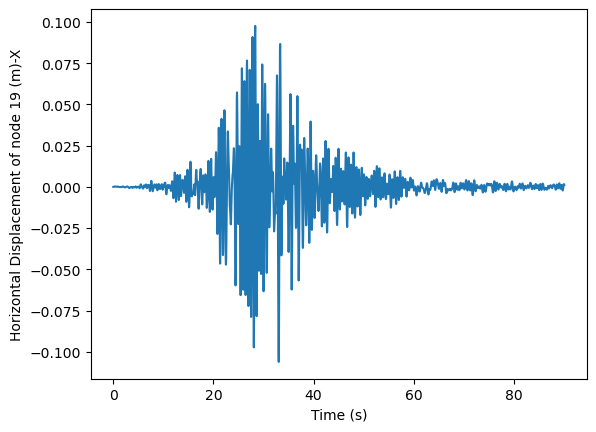

In [15]:
plt.plot(time, uRef_x)
plt.ylabel('Horizontal Displacement of node 19 (m)-X')
plt.xlabel('Time (s)')
plt.show()

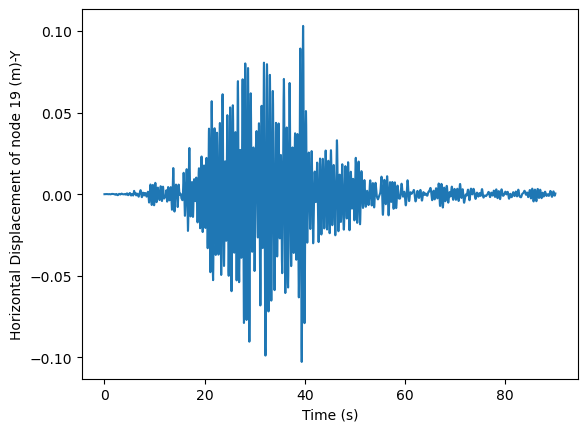

In [16]:
plt.plot(time, uRef_y)
plt.ylabel('Horizontal Displacement of node 19 (m)-Y')
plt.xlabel('Time (s)')
plt.show()

In [ ]:
plt.plot(time, u510_z)
plt.ylabel('Horizontal Displacement of node 19 (m)-Z')
plt.xlabel('Time (s)')
plt.show()